# Wildfire Modeling Pipeline
This notebook walks through data ingestion, feature engineering, model training, and diagnostics for wildfire forecasting. Use the numbered sections to run cells sequentially from raw inputs through evaluation and reporting.

## 1. Fire Data Ingestion and EDA
Load the historical wildfire records, attach the nearest station metadata, and perform exploratory analysis before creating distance-based subsets.

In [16]:
import numpy as np
import pandas as pd
from pathlib import Path

import lightgbm as lgb
from lightgbm import LGBMRegressor

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import BallTree
from sklearn.metrics import (
    mean_squared_error,
    roc_auc_score,
    r2_score,
)

import holidays

DATA_DIR = Path('../shared_data/')  # change to your local path
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [17]:
# ---- 1.1 Load wildfires ----
fires_path = DATA_DIR / 'wildfires_fires.parquet'

fires = pd.read_parquet(
    fires_path,
    columns=[
        'FIRE_SIZE',
        'DISCOVERY_DATE',
        'STATE',
        'STAT_CAUSE_CODE',
        'LATITUDE',
        'LONGITUDE',
    ],
)

# Convert DISCOVERY_DATE to datetime
if not np.issubdtype(fires['DISCOVERY_DATE'].dtype, np.datetime64):
    fires['DISCOVERY_DATE'] = pd.to_datetime(fires['DISCOVERY_DATE'])

fires = fires.rename(columns={'DISCOVERY_DATE': 'date'})

# Filter date range 1992–2015
fires = fires[
    (fires['date'].dt.year >= 1992) & (fires['date'].dt.year <= 2015)
]

# Drop rows without coordinates
fires = fires.dropna(subset=['LATITUDE', 'LONGITUDE'])
fires.head()

,FIRE_SIZE,date,STATE,STAT_CAUSE_CODE,LATITUDE,LONGITUDE
0,0.10,2005-02-02,CA,9.0,40.036944,-121.005833
1,0.25,2004-05-12,CA,1.0,38.933056,-120.404444
2,0.10,2004-05-31,CA,5.0,38.984167,-120.735556
3,0.10,2004-06-28,CA,1.0,38.559167,-119.913333
4,0.10,2004-06-28,CA,1.0,38.559167,-119.933056


In [ ]:
# ---- 1.2 Attach closest weather station to each fire ----
cities_path = DATA_DIR / 'cities.csv'
stations = pd.read_csv(cities_path)

# Keep one row per station with coordinates
stations = stations[["station_id", "latitude", "longitude"]].drop_duplicates('station_id')

# Build BallTree (coordinates in radians)
station_coords = np.radians(stations[['latitude', 'longitude']].values)
fire_coords = np.radians(fires[['LATITUDE', 'LONGITUDE']].values)

tree = BallTree(station_coords, metric='haversine')
dist_rad, ind = tree.query(fire_coords, k=1)

fires['station_id'] = stations.iloc[ind.flatten()]['station_id'].values
fires['dist_to_station_km'] = dist_rad.flatten() * 6371.0  # earth radius ~6371 km

fires.head()

,FIRE_SIZE,date,STATE,STAT_CAUSE_CODE,LATITUDE,LONGITUDE,station_id,dist_to_station_km
0,0.10,2005-02-02,CA,9.0,40.036944,-121.005833,72488,143.878212
1,0.25,2004-05-12,CA,1.0,38.933056,-120.404444,72488,60.782146
2,0.10,2004-05-31,CA,5.0,38.984167,-120.735556,72483,78.251133
3,0.10,2004-06-28,CA,1.0,38.559167,-119.913333,72488,68.430576
4,0.10,2004-06-28,CA,1.0,38.559167,-119.933056,72488,68.768514


### 1.3 Exploratory data analysis (EDA)

In this section we explore the raw wildfire and station-mapped data before building models.

We focus on:

- The distribution of distances from each fire to its nearest weather station.
- The distribution of burned area per fire (on both raw and log scales).
- Basic counts per state and over time.

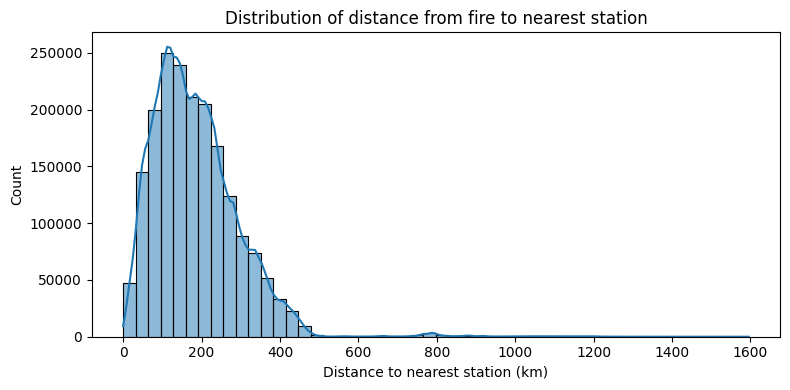

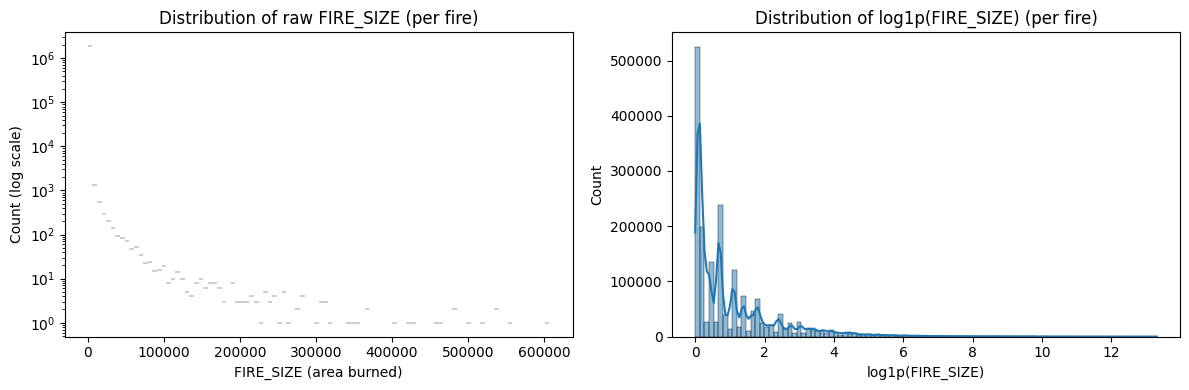

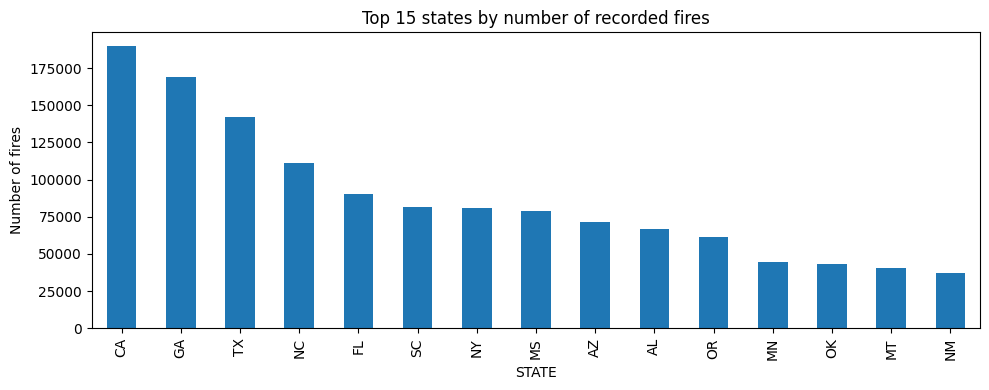

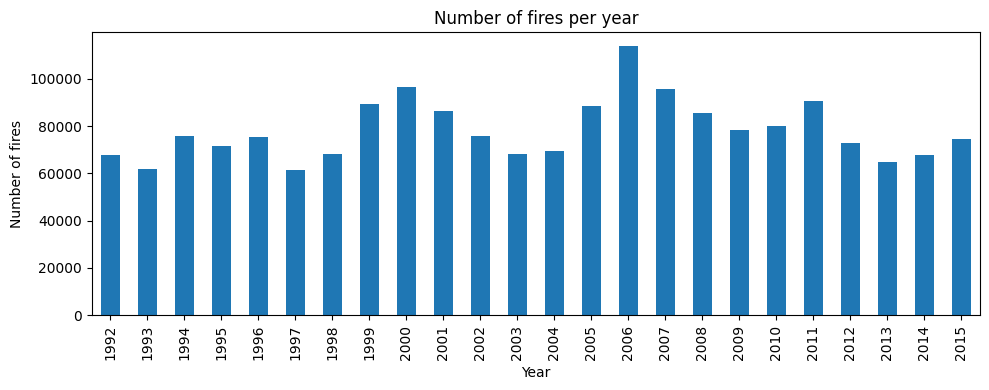

In [ ]:
# ---- 1.3 EDA: distance to nearest station and burned area ----
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure we have the station distance in km (computed in the previous cell)
assert 'dist_to_station_km' in fires.columns, 'dist_to_station_km missing; run the station mapping cell first.'

# Distribution of distance to nearest station
plt.figure(figsize=(8, 4))
sns.histplot(fires['dist_to_station_km'], bins=50, kde=True)
plt.xlabel('Distance to nearest station (km)')
plt.title('Distribution of distance from fire to nearest station')
plt.tight_layout()
plt.show()

# Raw area burned per fire
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(fires['FIRE_SIZE'], bins=100, log_scale=(False, True))
plt.xlabel('FIRE_SIZE (area burned)')
plt.ylabel('Count (log scale)')
plt.title('Distribution of raw FIRE_SIZE (per fire)')

# Log-transformed area per fire
plt.subplot(1, 2, 2)
log_fire_size = np.log1p(fires['FIRE_SIZE'])
sns.histplot(log_fire_size, bins=100, kde=True)
plt.xlabel('log1p(FIRE_SIZE)')
plt.title('Distribution of log1p(FIRE_SIZE) (per fire)')

plt.tight_layout()
plt.show()

# EDA: simple counts per state and over time
plt.figure(figsize=(10, 4))
fires['STATE'].value_counts().head(15).plot(kind='bar')
plt.title('Top 15 states by number of recorded fires')
plt.xlabel('STATE')
plt.ylabel('Number of fires')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
fires['date'].dt.year.value_counts().sort_index().plot(kind='bar')
plt.title('Number of fires per year')
plt.xlabel('Year')
plt.ylabel('Number of fires')
plt.tight_layout()
plt.show()

The log-fire size distribution shows spikes that likely stem from reporting or rounding, so follow-up modeling should treat extreme bins with care.

In [ ]:
# ---- 1.4 Create fire-level distance-pruned versions ----
# We will create three variants of the raw fire table where we drop fires
# whose nearest-station distance is below a chosen cutoff (100, 200, 400 km).
# NOTE: pruning is done at the **fire-level**, before any aggregation.

cutoffs_km = [100, 200, 400]
fires_pruned = {}

for d in cutoffs_km:
    mask = fires['dist_to_station_km'] <= d
    fires_pruned[d] = fires.loc[mask].copy()
    print(f"Cutoff {d} km: keeping {mask.sum():,} fires out of {len(fires):,} total")

# Keep the original (unpruned) fires table for reference as well
fires_pruned[0] = fires.copy()  # 0 km = no pruning
print("Stored distance-pruned fire tables in fires_pruned dict (keys: all, 100, 200, 400)")

Cutoff 100 km: keeping 423,100 fires out of 1,880,465 total
Cutoff 200 km: keeping 1,146,412 fires out of 1,880,465 total
Cutoff 200 km: keeping 1,146,412 fires out of 1,880,465 total
Cutoff 400 km: keeping 1,820,296 fires out of 1,880,465 total
Stored distance-pruned fire tables in fires_pruned dict (keys: all, 100, 200, 400)
Cutoff 400 km: keeping 1,820,296 fires out of 1,880,465 total
Stored distance-pruned fire tables in fires_pruned dict (keys: all, 100, 200, 400)


### 1.5 Distance-to-station distribution by cutoff
Visualize how the raw fire-to-station distance distribution is partitioned by the distance thresholds (0/no cutoff, 100, 200, 400 km). This helps confirm how much data each pruning step retains before aggregation.

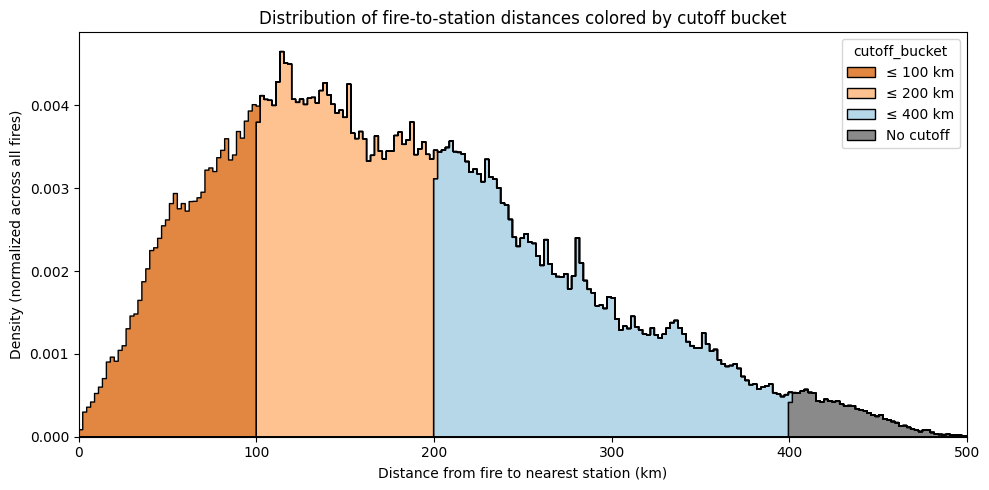

Share of fires within each cutoff bucket:
cutoff_bucket
≤ 100 km      22.5%
≤ 200 km     38.46%
≤ 400 km     35.84%
No cutoff      3.2%
Name: proportion, dtype: object


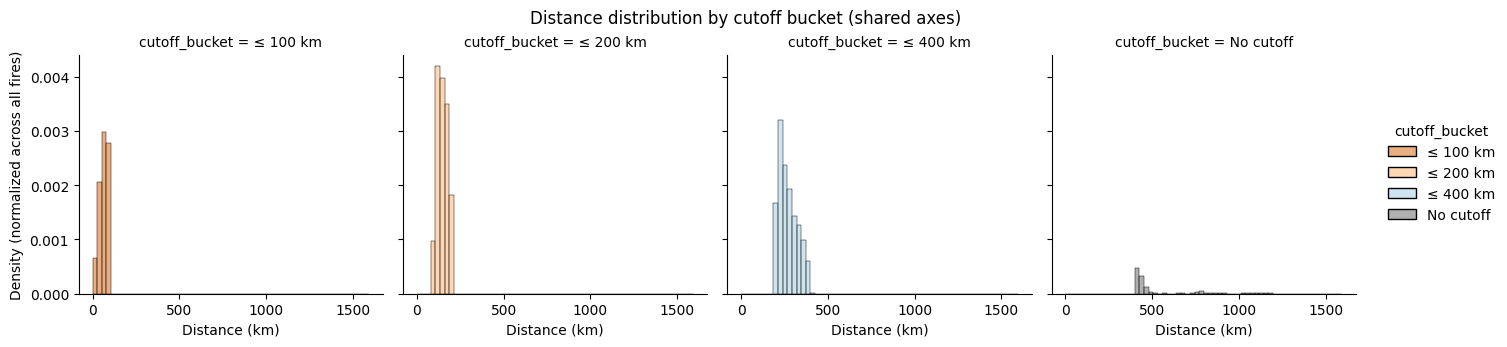

In [ ]:
# ---- 1.5 Distance distribution colored by cutoff ----
import matplotlib.pyplot as plt
import seaborn as sns

if 'fires' not in globals():
    raise ValueError('The raw `fires` DataFrame is not available; rerun the earlier ingestion cells.')
if 'dist_to_station_km' not in fires.columns:
    raise ValueError('dist_to_station_km missing; run the station mapping cell first.')

cutoff_bins = [0, 100, 200, 400, np.inf]
cutoff_labels = ['≤ 100 km', '≤ 200 km', '≤ 400 km', 'No cutoff']
fires_dist = fires[['dist_to_station_km']].copy()
fires_dist['cutoff_bucket'] = pd.cut(
    fires_dist['dist_to_station_km'],
    bins=cutoff_bins,
    labels=cutoff_labels,
    right=True,
    include_lowest=True,
)

plt.figure(figsize=(10, 5))
sns.histplot(
    data=fires_dist,
    x='dist_to_station_km',
    hue='cutoff_bucket',
    element='step',
    stat='density',
    common_norm=True,
    multiple='stack',
    palette=['#d95f02', '#fdae6b', '#9ecae1', '#636363']
)
plt.xlabel('Distance from fire to nearest station (km)')
plt.ylabel('Density (normalized across all fires)')
plt.title('Distribution of fire-to-station distances colored by cutoff bucket')
plt.xlim(0, min(500, fires_dist['dist_to_station_km'].max()))
plt.tight_layout()
plt.show()

g = sns.displot(
    data=fires_dist,
    x='dist_to_station_km',
    col='cutoff_bucket',
    hue='cutoff_bucket',
    stat='density',
    common_norm=True,
    multiple='layer',
    bins=60,
    height=3.5,
    aspect=1,
    palette=['#d95f02', '#fdae6b', '#9ecae1', '#636363'],
    facet_kws={'sharex': True, 'sharey': True}
)
g.set_axis_labels('Distance (km)', 'Density (normalized across all fires)')
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle('Distance distribution by cutoff bucket (shared axes)')

share_df = fires_dist['cutoff_bucket'].value_counts(normalize=True).reindex(cutoff_labels)
print('Share of fires within each cutoff bucket:')
print((share_df * 100).round(2).astype(str) + '%')

## 2. Station-Day Aggregation
Aggregate fire records to station-day targets and keep parallel versions for each pruning cutoff so downstream models can compare trade-offs.

In [ ]:
# ---- 2.1 Aggregate to station–day ----

# Optionally: restrict to fires within a maximum distance of their assigned station

# Set this to None to keep all fires, or to a value in km (e.g., 400) to drop very distant matches.
max_fire_station_distance_km = None  # e.g., 400
fires_for_agg = fires.copy()
if max_fire_station_distance_km is not None:
    fires_for_agg = fires_for_agg[fires_for_agg['dist_to_station_km'] <= max_fire_station_distance_km].copy()
    print(f"Using {len(fires_for_agg):,} fires within {max_fire_station_distance_km} km of a station (out of {len(fires):,})")

# Basic daily targets per station
daily_agg = (
    fires_for_agg.groupby(['station_id', 'date'])
    .agg(
        n_fires=('FIRE_SIZE', 'size'),
        area_burned=('FIRE_SIZE', 'sum'),
        min_dist_km=('dist_to_station_km', 'min'),
        mean_dist_km=('dist_to_station_km', 'mean'),
    )
    .reset_index()
)

# Cause counts per station–day (wide format)
cause_counts = (
    fires_for_agg.pivot_table(
        index=['station_id', 'date'],
        columns='STAT_CAUSE_CODE',
        values='FIRE_SIZE',  # any column, we just count
        aggfunc='count',
        fill_value=0,
    )
    .rename_axis(columns='cause_code')
)

# Make nicer column names: cause_1, cause_2, ...
cause_counts.columns = [f'cause_{int(c)}' for c in cause_counts.columns]
cause_counts = cause_counts.reset_index()

# Merge counts into daily_agg
fires_daily = daily_agg.merge(
    cause_counts, on=['station_id', 'date'], how='left',
).fillna(0)

fires_daily['any_fire'] = (fires_daily['n_fires'] > 0).astype(int)
fires_daily.head()

,station_id,date,n_fires,area_burned,min_dist_km,mean_dist_km,cause_1,cause_2,cause_3,cause_4,cause_5,cause_6,cause_7,cause_8,cause_9,cause_10,cause_11,cause_12,cause_13,any_fire
0,25563,1992-04-27,2,0.6,1088.703963,1089.427229,0,0,0,2,0,0,0,0,0,0,0,0,0,1
1,25563,1992-05-15,1,30.0,1545.583577,1545.583577,0,0,0,1,0,0,0,0,0,0,0,0,0,1
2,25563,1992-05-21,1,1.8,1109.410967,1109.410967,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,25563,1992-05-30,1,4.8,1023.593742,1023.593742,0,0,0,0,0,0,0,1,0,0,0,0,0,1
4,25563,1992-06-03,1,13.0,1000.697964,1000.697964,0,0,0,0,1,0,0,0,0,0,0,0,0,1


In [ ]:
# ---- 2.2 Aggregate pruned fires to station–day ----
# For each distance cutoff, build a station–day table analogous to `fires_daily`.

fires_daily_by_cutoff = {}

for d, fires_subset in fires_pruned.items():
    # Optionally mirror the max_fire_station_distance_km filter logic if desired
    fires_for_agg_d = fires_subset.copy()
    if max_fire_station_distance_km is not None:
        fires_for_agg_d = fires_for_agg_d[
            fires_for_agg_d['dist_to_station_km'] <= max_fire_station_distance_km
        ].copy()

    if fires_for_agg_d.empty:
        print(f"Warning: no fires left after filtering for cutoff {d} km; skipping.")
        continue

    daily_agg_d = (
        fires_for_agg_d.groupby(['station_id', 'date'])
        .agg(
            n_fires=('FIRE_SIZE', 'size'),
            area_burned=('FIRE_SIZE', 'sum'),
            min_dist_km=('dist_to_station_km', 'min'),
            mean_dist_km=('dist_to_station_km', 'mean'),
        )
        .reset_index()
    )

    cause_counts_d = (
        fires_for_agg_d.pivot_table(
            index=['station_id', 'date'],
            columns='STAT_CAUSE_CODE',
            values='FIRE_SIZE',
            aggfunc='count',
            fill_value=0,
        )
        .rename_axis(columns='cause_code')
    )
    cause_counts_d.columns = [f'cause_{int(c)}' for c in cause_counts_d.columns]
    cause_counts_d = cause_counts_d.reset_index()

    fires_daily_d = daily_agg_d.merge(
        cause_counts_d, on=['station_id', 'date'], how='left'
    ).fillna(0)
    fires_daily_d['any_fire'] = (fires_daily_d['n_fires'] > 0).astype(int)

    fires_daily_by_cutoff[d] = fires_daily_d
    print(
        f"Cutoff {d} km: {len(fires_daily_d):,} station-days with at least one fire event (post-aggregation)"
    )

# For backward compatibility, keep `fires_daily` as the unpruned (d=0) version if not already
if 0 in fires_daily_by_cutoff:
    fires_daily = fires_daily_by_cutoff[0]

Cutoff 100 km: 127,079 station-days with at least one fire event (post-aggregation)
Cutoff 200 km: 197,473 station-days with at least one fire event (post-aggregation)
Cutoff 200 km: 197,473 station-days with at least one fire event (post-aggregation)
Cutoff 400 km: 245,891 station-days with at least one fire event (post-aggregation)
Cutoff 400 km: 245,891 station-days with at least one fire event (post-aggregation)
Cutoff 0 km: 253,106 station-days with at least one fire event (post-aggregation)
Cutoff 0 km: 253,106 station-days with at least one fire event (post-aggregation)


## 3. Weather Features
Load station-level weather observations, aggregate to daily summaries, and engineer lagged features for forecasting.

In [ ]:
# ---- 3.1 Load weather (station-based) ----
weather_path = DATA_DIR / 'us_daily_weather_1992_2015.parquet'
weather = pd.read_parquet(weather_path)

# Ensure date is datetime
weather['date'] = pd.to_datetime(weather['date'])

# Restrict to 1992–2015
weather = weather[
    (weather['date'].dt.year >= 1992) & (weather['date'].dt.year <= 2015)
]

# Load station metadata (cities.csv)
cities_path = DATA_DIR / 'cities.csv'
cities_df = pd.read_csv(cities_path)

# Merge state info into weather via station_id
weather = weather.merge(
    cities_df[['station_id', 'state']].drop_duplicates('station_id'),
    on='station_id',
    how='left',
)

weather = weather.rename(
    columns={
        'state': 'STATE',
        'avg_temp_c': 'tavg',
        'min_temp_c': 'tmin',
        'max_temp_c': 'tmax',
        'precipitation_mm': 'prcp_1d',  # explicit 1-day precipitation
        'avg_wind_speed_kmh': 'wspd',
        'avg_sea_level_pres_hpa': 'pres',
    }
)

weather.head()

,station_id,city_name,date,season,tavg,tmin,tmax,prcp_1d,snow_depth_mm,avg_wind_dir_deg,wspd,peak_wind_gust_kmh,pres,sunshine_total_min,STATE
0,72518,Albany,1992-01-01,Winter,-8.3,-15.0,1.1,0.0,0.0,NaN,1.4,13.0,1035.9,546.0,New York
1,72518,Albany,1992-01-02,Winter,NaN,-13.3,1.1,0.0,0.0,NaN,3.2,16.6,NaN,221.0,New York
2,72518,Albany,1992-01-03,Winter,1.8,-3.3,7.2,0.0,0.0,NaN,3.6,13.0,1027.5,227.0,New York
3,72518,Albany,1992-01-04,Winter,1.7,-3.3,3.9,9.4,0.0,NaN,10.1,25.9,1018.5,0.0,New York
4,72518,Albany,1992-01-05,Winter,3.6,1.7,5.6,0.0,0.0,336.0,15.1,38.9,1009.7,24.0,New York


In [ ]:
# ---- 3.2 Aggregate station data to station–day ----
weather_daily = (
    weather.groupby(['station_id', 'date'])
    .agg(
        tavg=('tavg', 'mean'),
        tmin=('tmin', 'mean'),
        tmax=('tmax', 'mean'),
        prcp_1d=('prcp_1d', 'sum'),  # daily precip (1-day)
        wspd=('wspd', 'mean'),
        pres=('pres', 'mean'),
        STATE=('STATE', 'first'),
    )
    .reset_index()
)

weather_daily.head()

,station_id,date,tavg,tmin,tmax,prcp_1d,wspd,pres,STATE
0,70381,1992-01-01,3.8,3.3,4.4,13.2,31.7,NaN,Alaska
1,70381,1992-01-02,3.0,2.2,3.9,2.5,21.6,NaN,Alaska
2,70381,1992-01-03,2.3,0.0,3.9,2.0,12.2,NaN,Alaska
3,70381,1992-01-04,1.3,-0.6,3.3,0.0,11.2,NaN,Alaska
4,70381,1992-01-05,2.1,1.1,3.3,3.0,26.6,NaN,Alaska


In [ ]:
# ---- 3.3 Add lagged weather features (per station) ----
def add_lagged_features(
    df,
    group_col,
    date_col,
    base_cols,
    windows=(3, 7, 30),
    shift=1,
):
    """
    For each base_col, compute rolling means or sums over given windows,
    then shift by `shift` days to avoid using same-day info.
    """
    df = df.sort_values([group_col, date_col]).copy()

    for col in base_cols:
        for w in windows:
            roll = (
                df.groupby(group_col)[col]
                .transform(lambda x: x.rolling(w, min_periods=1).mean())
            )
            df[f'{col}_mean_{w}'] = roll.shift(shift)

    # Cumulative precipitation over 7 and 30 days, based on 1-day precip
    for w in [7, 30]:
        roll = (
            df.groupby(group_col)['prcp_1d']
            .transform(lambda x: x.rolling(w, min_periods=1).sum())
        )
        df[f'prcp_1d_sum_{w}'] = roll.shift(shift)

    return df

weather_feat = weather_daily.copy()

# Impute any remaining NaNs before building lags (per station)
weather_feat = weather_feat.set_index('station_id')
weather_feat = weather_feat.groupby(level=0).ffill().bfill()
weather_feat = weather_feat.reset_index()

weather_feat['year'] = weather_feat['date'].dt.year
weather_feat['month'] = weather_feat['date'].dt.month
weather_feat['doy'] = weather_feat['date'].dt.dayofyear

base_cols = ['tavg', 'tmin', 'tmax', 'prcp_1d', 'wspd', 'pres']

weather_feat = add_lagged_features(
    weather_feat,
    group_col='station_id',
    date_col='date',
    base_cols=base_cols,
)

# Drop first few rows where lags are NaN (from shift)
weather_feat = weather_feat.dropna().reset_index(drop=True)

weather_feat.head()

,station_id,date,tavg,tmin,tmax,prcp_1d,wspd,pres,STATE,year,...,prcp_1d_mean_7,prcp_1d_mean_30,wspd_mean_3,wspd_mean_7,wspd_mean_30,pres_mean_3,pres_mean_7,pres_mean_30,prcp_1d_sum_7,prcp_1d_sum_30
0,70381,1992-01-02,3.0,2.2,3.9,2.5,21.6,1018.5,Alaska,1992,...,13.200,13.200,31.700000,31.700000,31.700000,1018.5,1018.5,1018.5,13.2,13.2
1,70381,1992-01-03,2.3,0.0,3.9,2.0,12.2,1018.5,Alaska,1992,...,7.850,7.850,26.650000,26.650000,26.650000,1018.5,1018.5,1018.5,15.7,15.7
2,70381,1992-01-04,1.3,-0.6,3.3,0.0,11.2,1018.5,Alaska,1992,...,5.900,5.900,21.833333,21.833333,21.833333,1018.5,1018.5,1018.5,17.7,17.7
3,70381,1992-01-05,2.1,1.1,3.3,3.0,26.6,1018.5,Alaska,1992,...,4.425,4.425,15.000000,19.175000,19.175000,1018.5,1018.5,1018.5,17.7,17.7
4,70381,1992-01-06,1.0,-0.6,2.2,0.5,10.8,1018.5,Alaska,1992,...,4.140,4.140,16.666667,20.660000,20.660000,1018.5,1018.5,1018.5,20.7,20.7


## 4. Merge Weather + Fire Targets
Combine station-day weather features with fire outcomes plus calendar/holiday indicators for each cutoff.

In [ ]:
# ---- 4.1 Merge weather and fires on station + date + calendar / holiday features ----
data = weather_feat.merge(
    fires_daily, on=['station_id', 'date'], how='left'
)

# Replace NaNs in fire-related columns with 0
fire_cols = [c for c in data.columns if c.startswith('cause_')] + [
    'n_fires', 'area_burned', 'any_fire',
]
for c in fire_cols:
    if c in data.columns:
        data[c] = data[c].fillna(0)

# Transformed target for area
data['log_area_burned'] = np.log1p(data['area_burned'])

# Weekend indicator
data['is_weekend'] = data['date'].dt.weekday.isin([5, 6]).astype(int)

# US holidays
us_holidays = holidays.US()
data['holiday_name'] = data['date'].dt.date.map(us_holidays.get)
data['is_holiday'] = data['holiday_name'].notna().astype(int)
data['is_july4'] = (data['holiday_name'] == 'Independence Day').astype(int)

# Combined "weekend or holiday" flag (optional extra feature)
data['is_weekend_or_holiday'] = (
    (data['is_weekend'] == 1) | (data['is_holiday'] == 1)
).astype(int)

data.head()

,station_id,date,tavg,tmin,tmax,prcp_1d,wspd,pres,STATE,year,...,cause_11,cause_12,cause_13,any_fire,log_area_burned,is_weekend,holiday_name,is_holiday,is_july4,is_weekend_or_holiday
0,70381,1992-01-02,3.0,2.2,3.9,2.5,21.6,1018.5,Alaska,1992,...,0.0,0.0,0.0,0.0,0.0,0,None,0,0,0
1,70381,1992-01-03,2.3,0.0,3.9,2.0,12.2,1018.5,Alaska,1992,...,0.0,0.0,0.0,0.0,0.0,0,None,0,0,0
2,70381,1992-01-04,1.3,-0.6,3.3,0.0,11.2,1018.5,Alaska,1992,...,0.0,0.0,0.0,0.0,0.0,1,None,0,0,1
3,70381,1992-01-05,2.1,1.1,3.3,3.0,26.6,1018.5,Alaska,1992,...,0.0,0.0,0.0,0.0,0.0,1,None,0,0,1
4,70381,1992-01-06,1.0,-0.6,2.2,0.5,10.8,1018.5,Alaska,1992,...,0.0,0.0,0.0,0.0,0.0,0,None,0,0,0


In [ ]:
# ---- 4.2 Build merged feature tables for each distance cutoff ----
# We reuse `weather_feat` and merge with each `fires_daily_d`.

merged_by_cutoff = {}

for d, fires_daily_d in fires_daily_by_cutoff.items():
    data_d = weather_feat.merge(
        fires_daily_d, on=['station_id', 'date'], how='left'
    )

    # Fire-related columns: cause_*, n_fires, area_burned, any_fire
    fire_cols_d = [c for c in data_d.columns if c.startswith('cause_')] + [
        'n_fires', 'area_burned', 'any_fire',
    ]
    for c in fire_cols_d:
        if c in data_d.columns:
            data_d[c] = data_d[c].fillna(0)

    data_d['log_area_burned'] = np.log1p(data_d.get('area_burned', 0))

    data_d['is_weekend'] = data_d['date'].dt.weekday.isin([5, 6]).astype(int)
    us_holidays = holidays.US()
    data_d['holiday_name'] = data_d['date'].dt.date.map(us_holidays.get)
    data_d['is_holiday'] = data_d['holiday_name'].notna().astype(int)
    data_d['is_july4'] = (data_d['holiday_name'] == 'Independence Day').astype(int)
    data_d['is_weekend_or_holiday'] = (
        (data_d['is_weekend'] == 1) | (data_d['is_holiday'] == 1)
    ).astype(int)

    merged_by_cutoff[d] = data_d
    print(f"Built merged weather+fire table for cutoff {d} km with {len(data_d):,} rows")

# For backward compatibility, keep `data` as the unpruned version (d=0)
if 0 in merged_by_cutoff:
    data = merged_by_cutoff[0]

Built merged weather+fire table for cutoff 100 km with 424,165 rows
Built merged weather+fire table for cutoff 200 km with 424,165 rows
Built merged weather+fire table for cutoff 200 km with 424,165 rows
Built merged weather+fire table for cutoff 400 km with 424,165 rows
Built merged weather+fire table for cutoff 400 km with 424,165 rows
Built merged weather+fire table for cutoff 0 km with 424,165 rows
Built merged weather+fire table for cutoff 0 km with 424,165 rows


### 4.3 Calendar influence on cause mix
We now dig into how ignition causes shift on weekends, holidays, and Independence Day. The goal is to see whether human-driven causes (e.g., fireworks) are overrepresented on those dates and to capture any seasonal spikes that may deserve tailored mitigation.

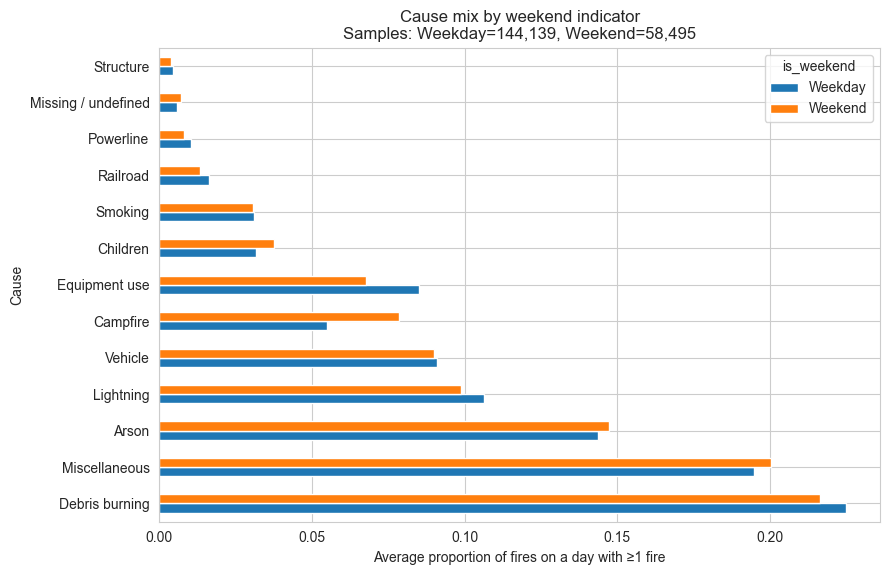

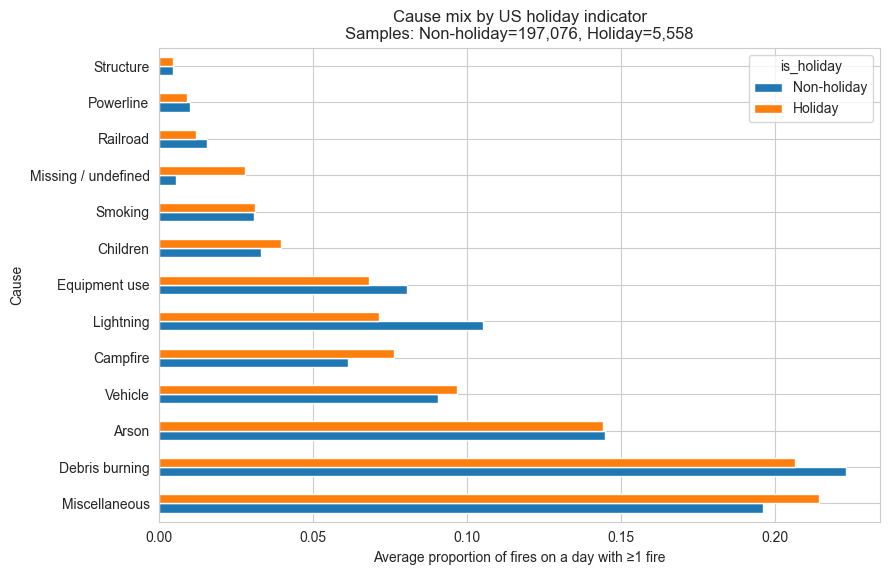

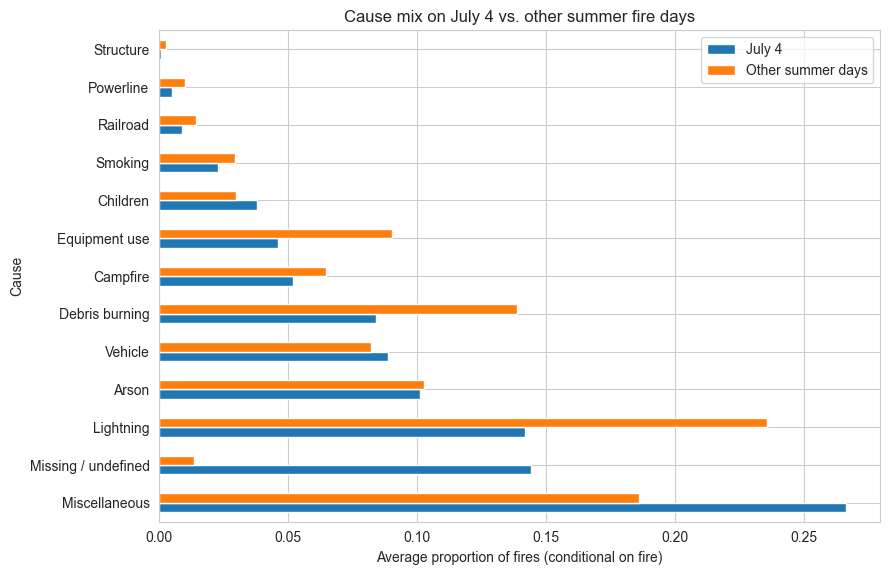

Causes most overrepresented on July 4 (Δ proportion):
Missing / undefined    0.130770
Miscellaneous          0.079986
Children               0.008436
Vehicle                0.006667
Arson                 -0.001513
Structure             -0.002088
Railroad              -0.005116
Powerline             -0.005380
Smoking               -0.006376
Campfire              -0.012885
dtype: float64


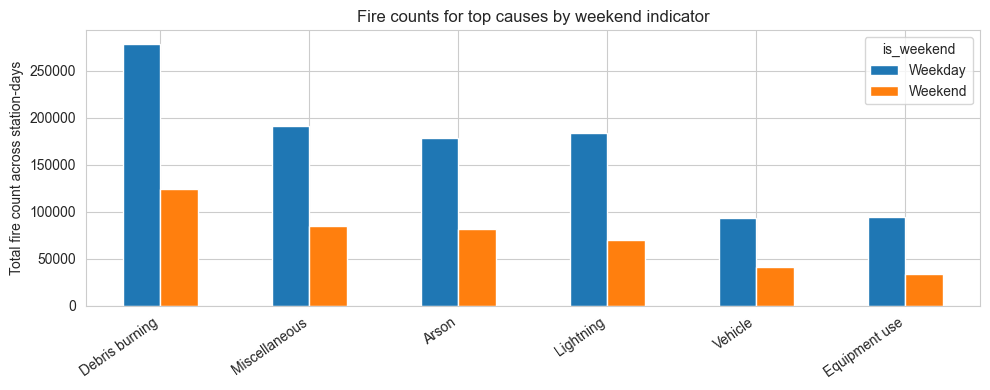

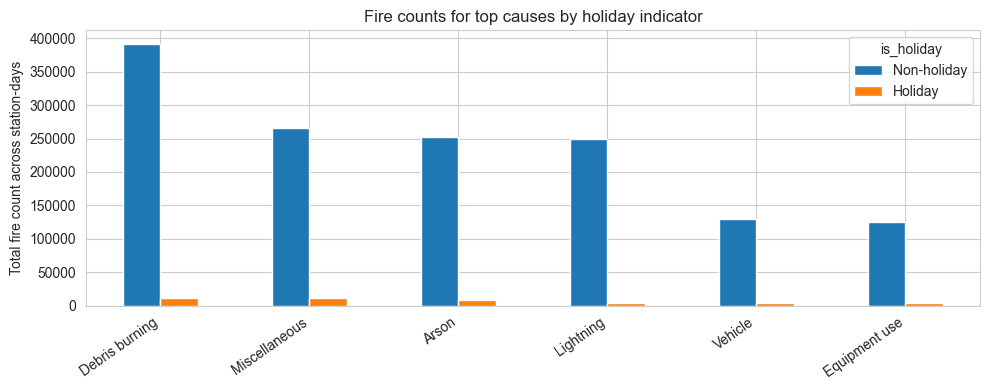

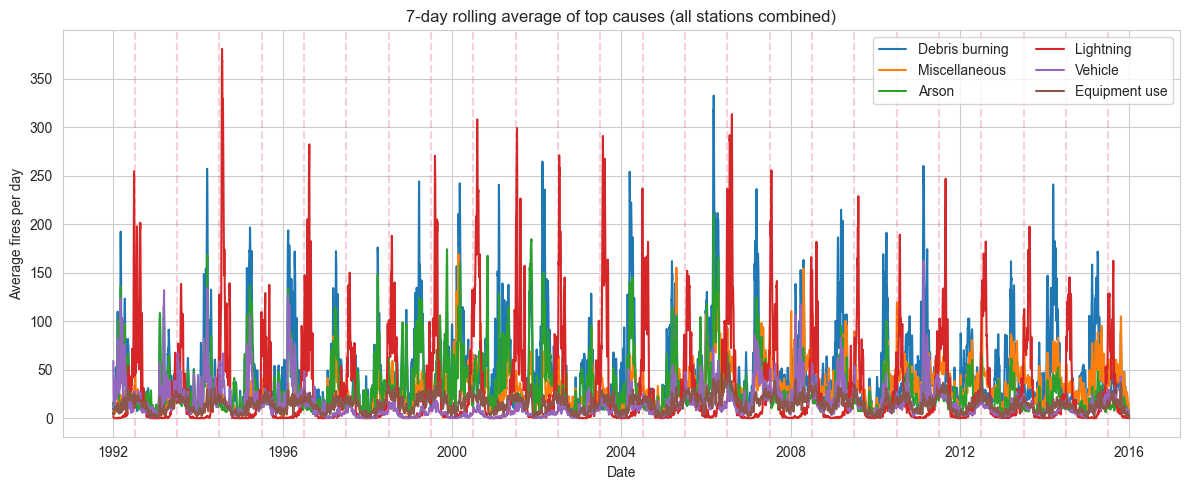

In [ ]:
# ---- 4.3 Cause proportions on weekends, holidays, and July 4 ----
import matplotlib.pyplot as plt
import seaborn as sns

CAUSE_COLUMN_TO_NAME = globals().get('CAUSE_COLUMN_TO_NAME', {
    'cause_1': 'Lightning',
    'cause_2': 'Equipment use',
    'cause_3': 'Smoking',
    'cause_4': 'Campfire',
    'cause_5': 'Debris burning',
    'cause_6': 'Railroad',
    'cause_7': 'Arson',
    'cause_8': 'Children',
    'cause_9': 'Miscellaneous',
    'cause_10': 'Missing / undefined',
    'cause_11': 'Powerline',
    'cause_12': 'Structure',
    'cause_13': 'Vehicle',
})

cause_cols = [c for c in data.columns if c.startswith('cause_') and not c.endswith('_prop')]
if not cause_cols:
    raise ValueError("No cause_* columns available; run the aggregation pipeline first.")

fire_days = data.loc[data['n_fires'] > 0].copy()
if fire_days.empty:
    raise ValueError("`data` has no station-days with fires; cannot build cause proportions.")

fire_days['n_fires_safe'] = fire_days['n_fires'].clip(lower=1)
for col in cause_cols:
    fire_days[f"{col}_prop"] = fire_days[col] / fire_days['n_fires_safe']

cause_prop_cols = [f"{col}_prop" for col in cause_cols]
prop_name_map = {
    f"{col}_prop": CAUSE_COLUMN_TO_NAME.get(col, col) for col in cause_cols
}
count_name_map = {col: CAUSE_COLUMN_TO_NAME.get(col, col) for col in cause_cols}

sns.set_style('whitegrid')

def plot_cause_mix_by_flag(flag_col, label_zero, label_one, title_suffix):
    flag_counts = fire_days[flag_col].value_counts().to_dict()
    mix = (
        fire_days.groupby(flag_col)[cause_prop_cols]
        .mean()
        .T
    )
    mix.index = [prop_name_map[idx] for idx in mix.index]
    mix = mix.sort_values(by=mix.columns[-1], ascending=False)
    renamed_cols = {0: label_zero, 1: label_one}
    mix = mix.rename(columns=renamed_cols)

    fig, ax = plt.subplots(figsize=(9, max(4, 0.45 * len(mix))))
    mix.plot(kind='barh', ax=ax)
    ax.set_xlabel('Average proportion of fires on a day with ≥1 fire')
    ax.set_ylabel('Cause')
    ax.set_title(
        f"Cause mix by {title_suffix}\nSamples: {label_zero}={flag_counts.get(0, 0):,}, "
        f"{label_one}={flag_counts.get(1, 0):,}"
    )
    fig.tight_layout()
    plt.show()

plot_cause_mix_by_flag('is_weekend', 'Weekday', 'Weekend', 'weekend indicator')
plot_cause_mix_by_flag('is_holiday', 'Non-holiday', 'Holiday', 'US holiday indicator')

def compare_july4_to_summer():
    july4 = fire_days.loc[fire_days['is_july4'] == 1]
    summer_mask = fire_days['date'].dt.month.isin([6, 7, 8])
    summer_non_july4 = fire_days.loc[summer_mask & (fire_days['is_july4'] == 0)]

    if july4.empty or summer_non_july4.empty:
        print('Not enough July 4 or summer observations to compare cause distributions.')
        return

    mean_july4 = july4[cause_prop_cols].mean()
    mean_summer = summer_non_july4[cause_prop_cols].mean()
    comp_df = pd.DataFrame({
        'July 4': mean_july4,
        'Other summer days': mean_summer,
    })
    comp_df.index = [prop_name_map[idx] for idx in comp_df.index]
    comp_df = comp_df.sort_values('July 4', ascending=False)

    fig, ax = plt.subplots(figsize=(9, max(4, 0.45 * len(comp_df))))
    comp_df.plot(kind='barh', ax=ax)
    ax.set_xlabel('Average proportion of fires (conditional on fire)')
    ax.set_ylabel('Cause')
    ax.set_title('Cause mix on July 4 vs. other summer fire days')
    fig.tight_layout()
    plt.show()

    delta = (mean_july4 - mean_summer)
    delta.index = [prop_name_map[idx] for idx in delta.index]
    print('Causes most overrepresented on July 4 (Δ proportion):')
    print(delta.sort_values(ascending=False).head(10))

compare_july4_to_summer()

num_top_causes = min(6, len(cause_cols))
top_cause_cols = (
    fire_days[cause_cols]
    .sum()
    .sort_values(ascending=False)
    .head(num_top_causes)
    .index
)

def plot_cause_counts_by_flag(flag_col, label_zero, label_one, title_suffix):
    counts = (
        fire_days.groupby(flag_col)[list(top_cause_cols)]
        .sum()
        .rename(index={0: label_zero, 1: label_one})
    )
    counts = counts.rename(columns=count_name_map)

    fig, ax = plt.subplots(figsize=(10, 4))
    counts.T.plot(kind='bar', ax=ax)
    ax.set_ylabel('Total fire count across station-days')
    ax.set_title(f"Fire counts for top causes by {title_suffix}")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=35, ha='right')
    fig.tight_layout()
    plt.show()

plot_cause_counts_by_flag('is_weekend', 'Weekday', 'Weekend', 'weekend indicator')
plot_cause_counts_by_flag('is_holiday', 'Non-holiday', 'Holiday', 'holiday indicator')

rolling_daily = (
    fire_days.groupby('date')[list(top_cause_cols)]
    .sum()
    .rolling(7, min_periods=1)
    .mean()
)
rolling_daily = rolling_daily.rename(columns=count_name_map)

fig, ax = plt.subplots(figsize=(12, 5))
for col in rolling_daily.columns:
    ax.plot(rolling_daily.index, rolling_daily[col], label=col)

july4_dates = fire_days.loc[fire_days['is_july4'] == 1, 'date'].dt.normalize().unique()
for dt in july4_dates:
    ax.axvline(dt, color='crimson', linestyle='--', alpha=0.2)

ax.set_title('7-day rolling average of top causes (all stations combined)')
ax.set_ylabel('Average fires per day')
ax.set_xlabel('Date')
ax.legend(loc='upper right', ncol=2)
fig.tight_layout()
plt.show()

In [ ]:
# ---- 5.1 Encode STATE and station_id ----
le_state = LabelEncoder()
data['STATE_LE'] = le_state.fit_transform(
    data['STATE'].fillna('UNK').astype(str)
)

le_station = LabelEncoder()
data['station_LE'] = le_station.fit_transform(
    data['station_id'].astype(str)
)

# ---- 5.2 Final feature list (excluding targets) ----
# Conservative pruning of highly correlated helpers:
pruned_cols = {
    'doy',              # keep month as the main seasonal indicator
    'prcp_1d_mean_7',   # keep prcp_1d_sum_7
    'prcp_1d_mean_30',  # keep prcp_1d_sum_30
}

exclude_cols = {
    'n_fires',
    'any_fire',
    'area_burned',
    'log_area_burned',
    'STATE',
    'station_id',
    'date',
    'holiday_name',
    'min_dist_km',      # <-- add
    'mean_dist_km',     # <-- add
} | set([c for c in data.columns if c.startswith('cause_')]) | pruned_cols

feature_cols = [c for c in data.columns if c not in exclude_cols]
len(feature_cols), feature_cols[:10]

(32,
 ['tavg',
  'tmin',
  'tmax',
  'prcp_1d',
  'wspd',
  'pres',
  'year',
  'month',
  'tavg_mean_3',
  'tavg_mean_7'])

## 5. Feature Engineering and Diagnostics
Encode categorical fields, define modeling feature sets, and inspect correlations before training.

In [ ]:
# ---- 5.3 Build feature/target sets per cutoff ----
# We reuse the same `feature_cols` definition for all pruned datasets.

features_by_cutoff = {}
targets_by_cutoff = {}

for d, data_d in merged_by_cutoff.items():
    # Encode STATE and station_id using the same encoders as the base data
    data_d = data_d.copy()
    data_d['STATE_LE'] = le_state.transform(
        data_d['STATE'].fillna('UNK').astype(str)
    )
    data_d['station_LE'] = le_station.transform(
        data_d['station_id'].astype(str)
    )

    X_d = data_d[feature_cols]
    y_count_d = data_d['n_fires']
    y_bin_d = data_d['any_fire']
    y_log_area_d = data_d['log_area_burned']

    features_by_cutoff[d] = X_d
    targets_by_cutoff[d] = {
        'n_fires': y_count_d,
        'any_fire': y_bin_d,
        'log_area_burned': y_log_area_d,
        'year': data_d['year'],
    }

    print(
        f"Prepared feature/target matrices for cutoff {d} km: X shape = {X_d.shape}"
    )

Prepared feature/target matrices for cutoff 100 km: X shape = (424165, 32)
Prepared feature/target matrices for cutoff 200 km: X shape = (424165, 32)
Prepared feature/target matrices for cutoff 200 km: X shape = (424165, 32)
Prepared feature/target matrices for cutoff 400 km: X shape = (424165, 32)
Prepared feature/target matrices for cutoff 400 km: X shape = (424165, 32)
Prepared feature/target matrices for cutoff 0 km: X shape = (424165, 32)
Prepared feature/target matrices for cutoff 0 km: X shape = (424165, 32)


Top 20 strongest absolute correlations among features:
tavg_mean_3   tavg_mean_7     0.978145
tavg_mean_7   tavg_mean_3     0.978145
tmin_mean_3   tmin_mean_7     0.972906
tmin_mean_7   tmin_mean_3     0.972906
tmax_mean_7   tmax_mean_3     0.970605
tmax_mean_3   tmax_mean_7     0.970605
tmin_mean_30  tmax_mean_30    0.966393
tmax_mean_30  tmin_mean_30    0.966393
tavg_mean_7   tavg_mean_30    0.959654
tavg_mean_30  tavg_mean_7     0.959654
tmax_mean_7   tmin_mean_7     0.953856
tmin_mean_7   tmax_mean_7     0.953856
              tmin_mean_30    0.953513
tmin_mean_30  tmin_mean_7     0.953513
tmax_mean_7   tmax_mean_30    0.950022
tmax_mean_30  tmax_mean_7     0.950022
tmax_mean_3   tmin_mean_3     0.938746
tmin_mean_3   tmax_mean_3     0.938746
tavg_mean_3   tavg            0.937518
tavg          tavg_mean_3     0.937518
dtype: float64


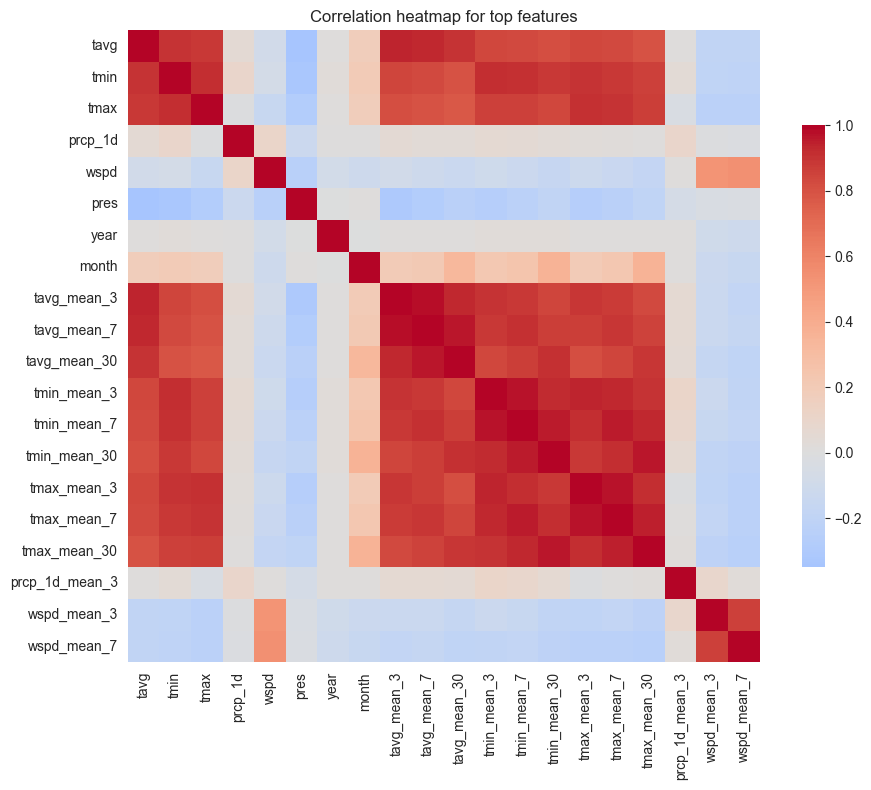

In [33]:
# Use only the feature columns and drop any remaining NaNs
corr_features = data[feature_cols].copy().dropna()

# Compute Pearson correlation
corr_matrix = corr_features.corr()

# Quick summary: show the top 20 most correlated pairs (by absolute value, excluding self)
corr_unstacked = (
    corr_matrix.abs()
    .where(~np.eye(corr_matrix.shape[0], dtype=bool))  # mask diagonal
    .unstack()
    .dropna()
    .sort_values(ascending=False)
)

print("Top 20 strongest absolute correlations among features:")
print(corr_unstacked.head(20))

# Optional: visualize a smaller subset (e.g., the most important features)
top_feats = feature_importance_area.sort_values(
    "importance", ascending=False
)["feature"].head(20).tolist() if "feature_importance_area" in globals() else feature_cols[:20]

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix.loc[top_feats, top_feats],
    cmap="coolwarm",
    center=0,
    square=True,
    cbar_kws={"shrink": 0.7},
)
plt.title("Correlation heatmap for top features")
plt.tight_layout()
plt.show()

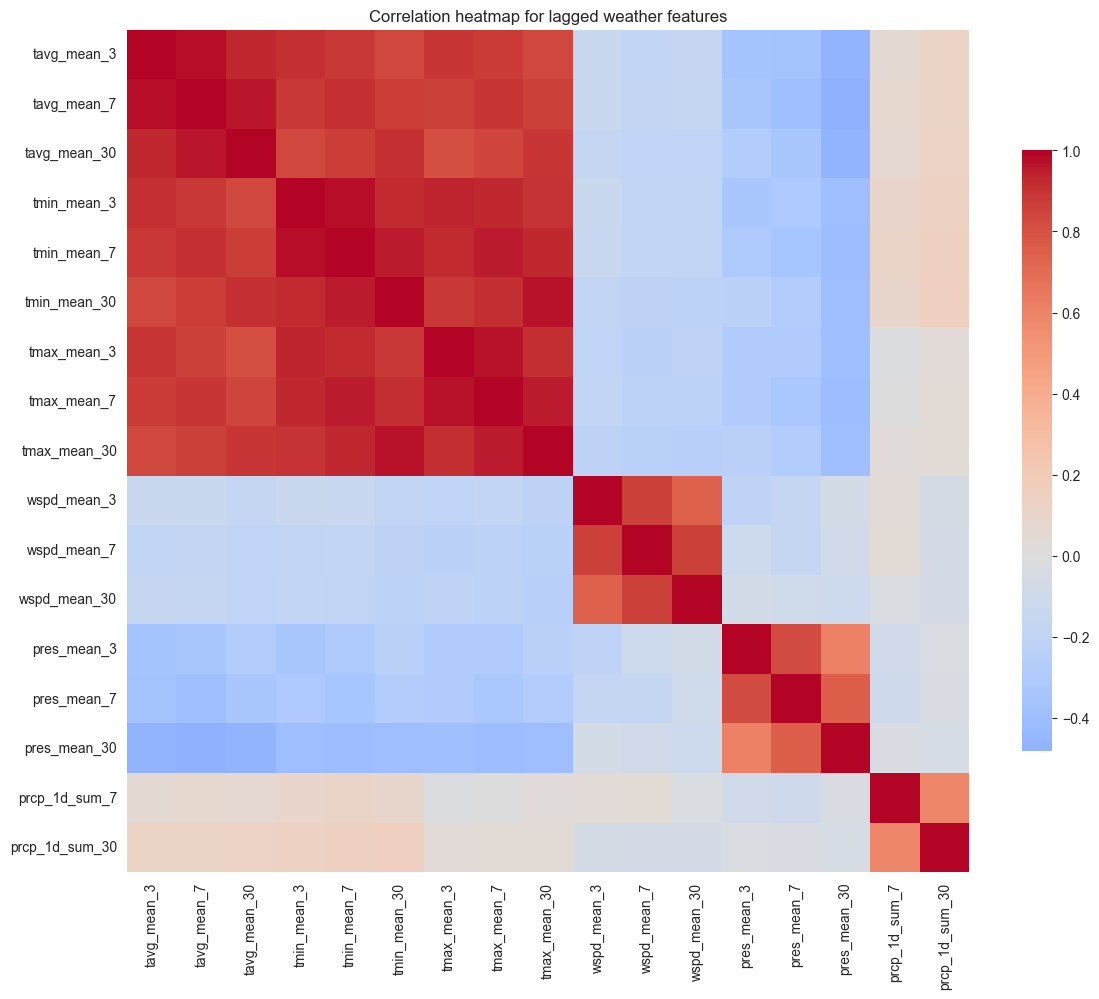

In [ ]:
# ---- 5.4 Correlation among weather lag features ----
lag_cols = [c for c in feature_cols if any(
    key in c for key in ["tavg_mean", "tmin_mean", "tmax_mean", "prcp_1d_sum", "wspd_mean", "pres_mean"]
)]

corr_lags = data[lag_cols].copy().dropna().corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_lags,
    cmap="coolwarm",
    center=0,
    square=True,
    cbar_kws={"shrink": 0.7},
)
plt.title("Correlation heatmap for lagged weather features")
plt.tight_layout()
plt.show()

In [ ]:
# ---- 6.1 Train / test split helper (per cutoff) ----
train_year_cutoff = 2011

def get_split_for_cutoff(d):
    """Return train/test feature matrices and targets for a given distance cutoff."""
    X_d = features_by_cutoff[d]
    tgt = targets_by_cutoff[d]
    year_d = tgt['year']

    train_mask = year_d < train_year_cutoff
    test_mask = ~train_mask

    splits = {
        'X_train': X_d.loc[train_mask].copy(),
        'X_test': X_d.loc[test_mask].copy(),
        'y_train_count': tgt['n_fires'].loc[train_mask].copy(),
        'y_test_count': tgt['n_fires'].loc[test_mask].copy(),
        'y_train_bin': tgt['any_fire'].loc[train_mask].copy(),
        'y_test_bin': tgt['any_fire'].loc[test_mask].copy(),
        'y_train_log_area': tgt['log_area_burned'].loc[train_mask].copy(),
        'y_test_log_area': tgt['log_area_burned'].loc[test_mask].copy(),
    }
    return splits

# Backward compatibility: expose the 0 km (unpruned) split
split_cutoff_0 = get_split_for_cutoff(0)
X_train = split_cutoff_0['X_train']
X_test = split_cutoff_0['X_test']
y_train_count = split_cutoff_0['y_train_count']
y_test_count = split_cutoff_0['y_test_count']
y_train_bin = split_cutoff_0['y_train_bin']
y_test_bin = split_cutoff_0['y_test_bin']
y_train_log_area = split_cutoff_0['y_train_log_area']
y_test_log_area = split_cutoff_0['y_test_log_area']

## 6. Train/Test Splits and Modeling
Define temporal splits for each cutoff and train LightGBM models for fire counts, occurrence, and burned area.

In [ ]:
# ---- 6.2 Train models for each distance cutoff ----
# We reuse the same LightGBM hyperparameters and year-based split.

results_by_cutoff = {}
trained_models_by_cutoff = globals().setdefault('trained_models_by_cutoff', {})

for d in sorted(features_by_cutoff.keys()):
    print("\n" + "=" * 80)
    print(f"Training models for distance cutoff: {d} km")
    print("=" * 80)

    splits = get_split_for_cutoff(d)
    X_train_d = splits['X_train']
    X_test_d = splits['X_test']
    y_train_count_d = splits['y_train_count']
    y_test_count_d = splits['y_test_count']
    y_train_bin_d = splits['y_train_bin']
    y_test_bin_d = splits['y_test_bin']
    y_train_log_area_d = splits['y_train_log_area']
    y_test_log_area_d = splits['y_test_log_area']

    # Count model
    lgb_train_d = lgb.Dataset(X_train_d, label=y_train_count_d)
    lgb_valid_d = lgb.Dataset(X_test_d, label=y_test_count_d)

    params_count = {
        'objective': 'poisson',
        'learning_rate': 0.05,
        'num_leaves': 64,
        'metric': 'rmse',
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 1,
        'seed': RANDOM_STATE,
    }

    model_count_d = lgb.train(
        params_count,
        lgb_train_d,
        num_boost_round=2000,
        valid_sets=[lgb_valid_d],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=200),
        ],
    )
    pred_count_d = model_count_d.predict(
        X_test_d, num_iteration=model_count_d.best_iteration
    )
    rmse_count_d = np.sqrt(mean_squared_error(y_test_count_d, pred_count_d))

    # Binary any-fire model
    lgb_train_bin_d = lgb.Dataset(X_train_d, label=y_train_bin_d)
    lgb_valid_bin_d = lgb.Dataset(X_test_d, label=y_test_bin_d)

    params_bin = {
        "objective": "binary",
        "learning_rate": 0.05,
        "num_leaves": 64,
        "metric": "auc",
        "feature_fraction": 0.8,
        "bagging_fraction": 0.8,
        "bagging_freq": 1,
        "seed": RANDOM_STATE,
    }

    model_bin_d = lgb.train(
        params_bin,
        lgb_train_bin_d,
        num_boost_round=2000,
        valid_sets=[lgb_valid_bin_d],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=200),
        ],
    )
    prob_any_fire_d = model_bin_d.predict(
        X_test_d, num_iteration=model_bin_d.best_iteration
    )
    auc_any_fire_d = roc_auc_score(y_test_bin_d, prob_any_fire_d)

    # Area model
    lgb_train_area_d = lgb.Dataset(X_train_d, label=y_train_log_area_d)
    lgb_valid_area_d = lgb.Dataset(X_test_d, label=y_test_log_area_d)

    params_area = {
        "objective": "regression",
        "learning_rate": 0.05,
        "num_leaves": 64,
        "metric": "rmse",
        "feature_fraction": 0.8,
        "bagging_fraction": 0.8,
        "bagging_freq": 1,
        "seed": RANDOM_STATE,
    }

    model_area_d = lgb.train(
        params_area,
        lgb_train_area_d,
        num_boost_round=2000,
        valid_sets=[lgb_valid_area_d],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=200),
        ],
    )
    pred_log_area_d = model_area_d.predict(
        X_test_d, num_iteration=model_area_d.best_iteration
    )
    rmse_log_area_d = np.sqrt(
        mean_squared_error(y_test_log_area_d, pred_log_area_d)
    )

    trained_models_by_cutoff[d] = {
        'cutoff': d,
        'splits': splits,
        'model_count': model_count_d,
        'model_bin': model_bin_d,
        'model_area': model_area_d,
        'pred_count': pred_count_d,
        'prob_any_fire': prob_any_fire_d,
        'pred_log_area': pred_log_area_d,
        'rmse_count': rmse_count_d,
        'auc_any_fire': auc_any_fire_d,
        'rmse_log_area': rmse_log_area_d,
    }

    results_by_cutoff[d] = {
        'rmse_count': rmse_count_d,
        'auc_any_fire': auc_any_fire_d,
        'rmse_log_area': rmse_log_area_d,
    }

    print(f"Cutoff {d} km -> Count RMSE: {rmse_count_d:.3f}")
    print(f"Cutoff {d} km -> AUC(any_fire): {auc_any_fire_d:.3f}")
    print(f"Cutoff {d} km -> RMSE(log1p area): {rmse_log_area_d:.3f}")


Training models for distance cutoff: 0 km
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044923 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5876
[LightGBM] [Info] Number of data points in the train set: 335427, number of used features: 32
[LightGBM] [Info] Start training from score 1.392832
Training until validation scores don't improve for 100 rounds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044923 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5876
[LightGBM] [Info] Number of data points in the train set: 335427, number of used features: 32
[LightGBM] [Info] Start training from score 1.392832
Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 6.0209
[200]	valid_0's rmse: 6.0209
[400]	valid_0's rmse: 5.93217
[400]	valid_0's rmse: 5.93217
[600]	valid_0's rmse: 5.8926


In [ ]:
# ---- 6.3 Summary of results ----
results_summary = pd.DataFrame.from_dict(
    results_by_cutoff, orient='index'
)
results_summary

,rmse_count,auc_any_fire,rmse_log_area
0,5.840682,0.891299,1.322676
100,2.137353,0.853950,0.872701
200,4.050201,0.875171,1.167761
400,5.789582,0.890340,1.310585


In [38]:
# Check if there is any inconsistency between any_fire and distance NaNs
print("Days with any_fire == 0 but min_dist_km not NaN:",
      ((data['any_fire'] == 0) & data['min_dist_km'].notna()).sum())

print("Days with any_fire == 1 but min_dist_km is NaN:",
      ((data['any_fire'] == 1) & data['min_dist_km'].isna()).sum())

Days with any_fire == 0 but min_dist_km not NaN: 0
Days with any_fire == 1 but min_dist_km is NaN: 0


In [39]:
# print the results summary
print("\nSummary of results by distance cutoff (km):")
print(results_summary)


Summary of results by distance cutoff (km):
     rmse_count  auc_any_fire  rmse_log_area
0      5.840682      0.891299       1.322676
100    2.137353      0.853950       0.872701
200    4.050201      0.875171       1.167761
400    5.789582      0.890340       1.310585


## 7. Performance vs. Distance Cutoff
Summarize how predictive metrics change as we tighten the maximum fire–station distance to understand the trade-off between coverage and accuracy.

   cutoff_km  rmse_count  auc_any_fire  rmse_log_area
0          0    5.840682      0.891299       1.322676
1        100    2.137353      0.853950       0.872701
2        200    4.050201      0.875171       1.167761
3        400    5.789582      0.890340       1.310585


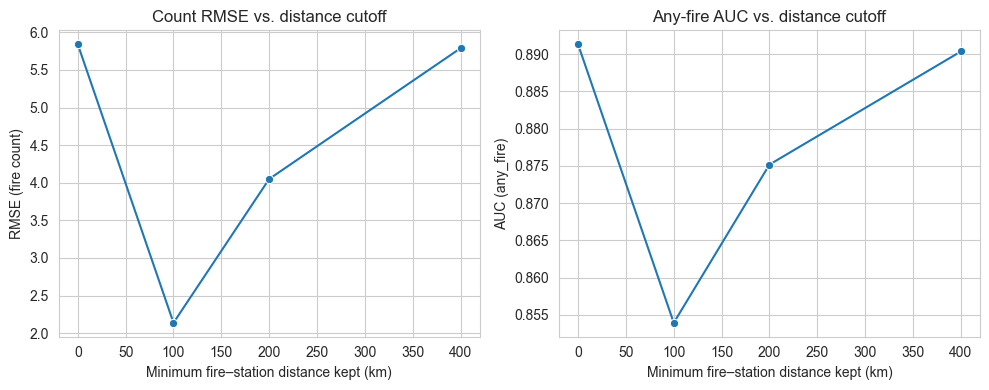

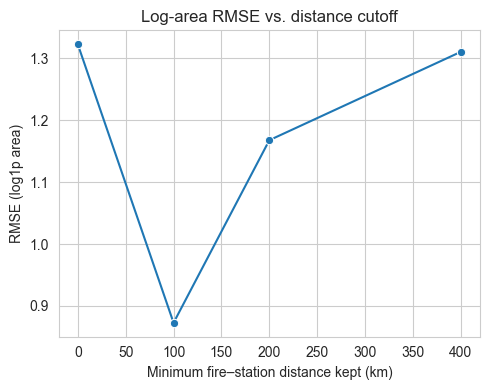

In [40]:
# ---- 7.1 Visualize metrics vs. distance cutoff ----
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

metrics_rows = []
for d, res in results_by_cutoff.items():
    metrics_rows.append({
        'cutoff_km': d,
        'rmse_count': res['rmse_count'],
        'auc_any_fire': res['auc_any_fire'],
        'rmse_log_area': res['rmse_log_area'],
    })

metrics_df = pd.DataFrame(metrics_rows).sort_values('cutoff_km')
print(metrics_df)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.lineplot(data=metrics_df, x='cutoff_km', y='rmse_count', marker='o')
plt.title('Count RMSE vs. distance cutoff')
plt.xlabel('Minimum fire–station distance kept (km)')
plt.ylabel('RMSE (fire count)')

plt.subplot(1, 2, 2)
sns.lineplot(data=metrics_df, x='cutoff_km', y='auc_any_fire', marker='o')
plt.title('Any-fire AUC vs. distance cutoff')
plt.xlabel('Minimum fire–station distance kept (km)')
plt.ylabel('AUC (any_fire)')

plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 4))
sns.lineplot(data=metrics_df, x='cutoff_km', y='rmse_log_area', marker='o')
plt.title('Log-area RMSE vs. distance cutoff')
plt.xlabel('Minimum fire–station distance kept (km)')
plt.ylabel('RMSE (log1p area)')
plt.tight_layout()
plt.show()

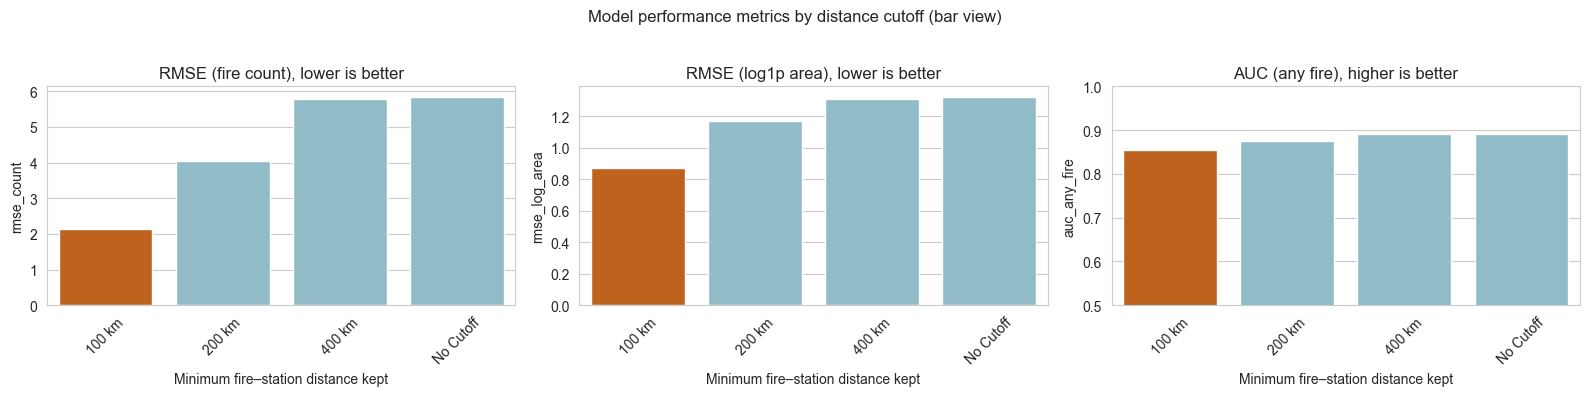

In [41]:
# ---- 7.2 Bar charts of RMSE / AUC vs. cutoff ----
if 'results_by_cutoff' not in globals():
    raise ValueError('results_by_cutoff is missing; run the training loop before plotting metrics.')

metrics_rows = []
for d, res in sorted(results_by_cutoff.items()):
    metrics_rows.append({
        'cutoff_km': d,
        'rmse_count': res['rmse_count'],
        'rmse_log_area': res['rmse_log_area'],
        'auc_any_fire': res['auc_any_fire'],
    })

if not metrics_rows:
    raise ValueError('results_by_cutoff is empty; nothing to plot.')

metrics_df_bar = pd.DataFrame(metrics_rows)
metrics_df_bar['cutoff_label'] = metrics_df_bar['cutoff_km'].apply(
    lambda x: 'No Cutoff' if x == 0 else f'{x} km'
 )
ordered_labels = [
    f'{d} km'
    for d in sorted(metrics_df_bar.loc[metrics_df_bar['cutoff_km'] > 0, 'cutoff_km'])
] + ['No Cutoff']
metrics_df_bar['cutoff_label'] = pd.Categorical(
    metrics_df_bar['cutoff_label'], categories=ordered_labels, ordered=True
 )
metrics_df_bar = metrics_df_bar.sort_values('cutoff_label')

highlight_color = '#d95f02'
base_color = '#88c0d0'
color_lookup = {
    label: (highlight_color if label == '100 km' else base_color)
    for label in ordered_labels
}

plot_specs = [
    ('rmse_count', 'RMSE (fire count), lower is better', False),
    ('rmse_log_area', 'RMSE (log1p area), lower is better', False),
    ('auc_any_fire', 'AUC (any fire), higher is better', True),
]

fig, axes = plt.subplots(1, len(plot_specs), figsize=(16, 4), sharex=False)
for ax, (col, title, ylim01) in zip(axes, plot_specs):
    sns.barplot(
        data=metrics_df_bar,
        x='cutoff_label',
        y=col,
        hue='cutoff_label',
        palette=color_lookup,
        ax=ax,
        legend=False,
    )
    ax.set_title(title)
    ax.set_xlabel('Minimum fire–station distance kept')
    ax.set_ylabel(col)
    if ylim01:
        ax.set_ylim(0.5, 1.0)
    ax.tick_params(axis='x', rotation=45)

plt.suptitle('Model performance metrics by distance cutoff (bar view)')
plt.tight_layout(rect=(0, 0, 1, 0.95))
plt.show()

## 8. Detailed Diagnostics per Cutoff

To inspect any one distance cutoff more closely, we wrap the train/test split and model training logic in helper functions so that plots and diagnostics stay aligned with the selected dataset. Once Section 6 has run, the trained boosters are cached in `trained_models_by_cutoff`, so rerunning the diagnostics later can reuse the stored models unless you pass `force_retrain=True`.

In [42]:
def train_models_for_cutoff(d, verbose=True, force_retrain=False):
    """Train the three LightGBM models for a single cutoff and return diagnostics."""
    cache = globals().setdefault('trained_models_by_cutoff', {})
    if not force_retrain and d in cache:
        if verbose:
            print(f"Reusing cached models for cutoff {d} km.")
        return cache[d]

    splits = get_split_for_cutoff(d)
    X_train = splits['X_train']
    X_test = splits['X_test']
    y_train_count = splits['y_train_count']
    y_test_count = splits['y_test_count']
    y_train_bin = splits['y_train_bin']
    y_test_bin = splits['y_test_bin']
    y_train_log_area = splits['y_train_log_area']
    y_test_log_area = splits['y_test_log_area']

    params_count = {
        'objective': 'poisson',
        'learning_rate': 0.05,
        'num_leaves': 64,
        'metric': 'rmse',
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 1,
        'seed': RANDOM_STATE,
    }
    params_bin = {
        'objective': 'binary',
        'learning_rate': 0.05,
        'num_leaves': 64,
        'metric': 'auc',
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 1,
        'seed': RANDOM_STATE,
    }
    params_area = {
        'objective': 'regression',
        'learning_rate': 0.05,
        'num_leaves': 64,
        'metric': 'rmse',
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 1,
        'seed': RANDOM_STATE,
    }

    # Train models
    lgb_train = lgb.Dataset(X_train, label=y_train_count)
    lgb_valid = lgb.Dataset(X_test, label=y_test_count)
    model_count = lgb.train(
        params_count,
        lgb_train,
        num_boost_round=2000,
        valid_sets=[lgb_valid],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=100),
        ],
    )
    pred_count = model_count.predict(
        X_test, num_iteration=model_count.best_iteration
    )
    rmse_count = np.sqrt(mean_squared_error(y_test_count, pred_count))

    lgb_train_bin = lgb.Dataset(X_train, label=y_train_bin)
    lgb_valid_bin = lgb.Dataset(X_test, label=y_test_bin)
    model_bin = lgb.train(
        params_bin,
        lgb_train_bin,
        num_boost_round=2000,
        valid_sets=[lgb_valid_bin],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=100),
        ],
    )
    prob_any_fire = model_bin.predict(
        X_test, num_iteration=model_bin.best_iteration
    )
    auc_any_fire = roc_auc_score(y_test_bin, prob_any_fire)

    lgb_train_area = lgb.Dataset(X_train, label=y_train_log_area)
    lgb_valid_area = lgb.Dataset(X_test, label=y_test_log_area)
    model_area = lgb.train(
        params_area,
        lgb_train_area,
        num_boost_round=2000,
        valid_sets=[lgb_valid_area],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=100),
        ],
    )
    pred_log_area = model_area.predict(
        X_test, num_iteration=model_area.best_iteration
    )
    rmse_log_area = np.sqrt(mean_squared_error(y_test_log_area, pred_log_area))

    results = {
        'cutoff': d,
        'splits': splits,
        'model_count': model_count,
        'model_bin': model_bin,
        'model_area': model_area,
        'pred_count': pred_count,
        'prob_any_fire': prob_any_fire,
        'pred_log_area': pred_log_area,
        'rmse_count': rmse_count,
        'auc_any_fire': auc_any_fire,
        'rmse_log_area': rmse_log_area,
    }
    cache[d] = results
    if verbose:
        print(
            f"Cutoff {d} km -> RMSE(count)={rmse_count:.3f}, "
            f"AUC(any_fire)={auc_any_fire:.3f}, RMSE(log_area)={rmse_log_area:.3f}"
        )
    return results

In [ ]:
# ---- 8.2 Plotting helpers (per cutoff) ----
import matplotlib.pyplot as plt
import seaborn as sns

def plot_class_balance(detailed_results, cutoff_km):
    """Visualize any-fire class balance for the selected cutoff."""
    y_test_bin = detailed_results['splits']['y_test_bin']
    labels = ['No Fire', 'Fire']
    sizes = [len(y_test_bin) - y_test_bin.sum(), y_test_bin.sum()]
    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, colors=['lightblue', 'salmon'], autopct='%1.1f%%', startangle=140)
    plt.title(f'Distribution of Any Fire Days (cutoff {cutoff_km} km, test set)')
    plt.show()

def plot_prediction_parity(detailed_results, cutoff_km):
    """Scatter plots comparing predictions vs. actuals for counts and burned area."""
    splits = detailed_results['splits']
    y_test_count = splits['y_test_count']
    pred_count = detailed_results['pred_count']
    y_test_log_area = splits['y_test_log_area']
    pred_log_area = detailed_results['pred_log_area']

    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=y_test_count, y=pred_count, s=5, alpha=0.4)
    max_val = max(y_test_count.max(), pred_count.max())
    plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='Ideal (y = x)')
    plt.xlabel('Actual fire count')
    plt.ylabel('Predicted fire count')
    plt.title(f'Predicted vs Actual Daily Fire Counts (cutoff {cutoff_km} km)')
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=y_test_log_area, y=pred_log_area, s=5, alpha=0.4)
    min_val = min(y_test_log_area.min(), pred_log_area.min())
    max_val = max(y_test_log_area.max(), pred_log_area.max())
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal (y = x)')
    plt.xlabel('Actual log1p(area_burned)')
    plt.ylabel('Predicted log1p(area_burned)')
    plt.title(f'Predicted vs Actual Log Area Burned (cutoff {cutoff_km} km)')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_area_feature_importance(detailed_results, cutoff_km, top_n=15):
    """Bar chart of the most important features for the area model."""
    model_area = detailed_results['model_area']
    importances_area = model_area.feature_importance(importance_type='gain')
    feature_importance_area = pd.DataFrame({
        'feature': feature_cols,
        'importance': importances_area,
    }).sort_values('importance', ascending=False)
    top_features_area = feature_importance_area.head(top_n)

    plt.figure(figsize=(8, 6))
    sns.barplot(data=top_features_area, x='importance', y='feature', orient='h')
    plt.title(f'Top {top_n} Features for Area Model (cutoff {cutoff_km} km)')
    plt.xlabel('Importance (gain)')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

def plot_log_area_distribution(detailed_results, cutoff_km):
    """Show log-area distributions for train and test splits."""
    splits = detailed_results['splits']
    y_train_log_area = splits['y_train_log_area']
    y_test_log_area = splits['y_test_log_area']

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(y_train_log_area, bins=50, kde=True)
    plt.title(f'Train log1p(area_burned) – cutoff {cutoff_km} km')
    plt.xlabel('log1p(area_burned)')

    plt.subplot(1, 2, 2)
    sns.histplot(y_test_log_area, bins=50, kde=True)
    plt.title(f'Test log1p(area_burned) – cutoff {cutoff_km} km')
    plt.xlabel('log1p(area_burned)')
    plt.tight_layout()
    plt.show()

    print('Train log-area:')
    print(y_train_log_area.describe())
    print('\nTest log-area:')
    print(y_test_log_area.describe())

## 9. Cause-Proportion Modeling per Cutoff

We reuse the same cutoff selection so that the multi-output regression on ignition causes stays aligned with the diagnostics above.

In [ ]:
# ---- 9.1 Cause proportion helper (per cutoff) ----
def train_cause_model_for_cutoff(d):
    data_d = merged_by_cutoff[d].copy()
    cause_cols = [c for c in data_d.columns if c.startswith('cause_')]
    if not cause_cols:
        raise ValueError("No cause columns found in merged dataset.")

    data_cause = data_d[data_d['n_fires'] > 0].copy()
    for c in cause_cols:
        data_cause[c + '_prop'] = data_cause[c] / data_cause['n_fires']
    target_prop_cols = [c + '_prop' for c in cause_cols]

    train_mask_cause = data_cause['year'] < train_year_cutoff
    test_mask_cause = ~train_mask_cause

    available_feature_cols = [col for col in feature_cols if col in data_cause.columns]
    if not available_feature_cols:
        raise KeyError(
            "None of the expected feature columns are present in the cause dataset. "
            "Check earlier preprocessing steps to ensure feature engineering was applied before merging."
        )

    missing_cols = sorted(set(feature_cols) - set(available_feature_cols))
    if missing_cols:
        print(
            f"Warning: dropping {len(missing_cols)} feature(s) missing from cause dataset for cutoff {d}: {missing_cols[:5]}"
            + (" ..." if len(missing_cols) > 5 else "")
        )

    X_train_cause = data_cause.loc[train_mask_cause, available_feature_cols]
    X_test_cause = data_cause.loc[test_mask_cause, available_feature_cols]
    Y_train_cause = data_cause.loc[train_mask_cause, target_prop_cols].values
    Y_test_cause = data_cause.loc[test_mask_cause, target_prop_cols].values

    base_reg = LGBMRegressor(
        objective='regression',
        learning_rate=0.05,
        num_leaves=64,
        n_estimators=800,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_STATE,
    )
    multi_reg = MultiOutputRegressor(base_reg)
    multi_reg.fit(X_train_cause, Y_train_cause)

    Y_pred_cause = multi_reg.predict(X_test_cause)
    Y_pred_cause = np.clip(Y_pred_cause, 0, None)
    row_sums = Y_pred_cause.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1
    Y_pred_cause = Y_pred_cause / row_sums

    mse_props = mean_squared_error(Y_test_cause.reshape(-1), Y_pred_cause.reshape(-1))
    eps = 1e-12
    ce_per_day = -np.sum(Y_test_cause * np.log(Y_pred_cause + eps), axis=1)
    ce_mean = ce_per_day.mean()

    global_dist = Y_train_cause.sum(axis=0)
    global_dist = global_dist / global_dist.sum()
    baseline_pred = np.tile(global_dist, (Y_test_cause.shape[0], 1))
    ce_baseline = -np.sum(Y_test_cause * np.log(baseline_pred + eps), axis=1).mean()
    mse_baseline = mean_squared_error(
        Y_test_cause.reshape(-1), baseline_pred.reshape(-1)
    )

    return {
        'cutoff': d,
        'model': multi_reg,
        'feature_cols': available_feature_cols,
        'target_prop_cols': target_prop_cols,
        'Y_test': Y_test_cause,
        'Y_pred': Y_pred_cause,
        'metrics': {
            'mse_props': mse_props,
            'ce_mean': ce_mean,
            'baseline_ce': ce_baseline,
            'baseline_mse': mse_baseline,
        },
    }

In [ ]:
# ---- 9.2 Cause helpers and cutoff report driver ----
def report_cause_metrics(cause_results):
    metrics = cause_results['metrics']
    cutoff = cause_results['cutoff']
    print(f"Cutoff {cutoff} km -> MSE on cause proportions: {metrics['mse_props']:.5f}")
    print(f"Cutoff {cutoff} km -> Mean cross-entropy per day: {metrics['ce_mean']:.3f}")
    print(f"Baseline CE: {metrics['baseline_ce']:.3f}")
    print(f"Baseline MSE: {metrics['baseline_mse']:.5f}")

def plot_cause_feature_importances(cause_results, cutoff_km, cause_names=None, top_k=10):
    target_prop_cols = cause_results['target_prop_cols']
    feature_cols_used = cause_results['feature_cols']
    if cause_names is None:
        cause_names = target_prop_cols[: min(2, len(target_prop_cols))]
    multi_reg = cause_results['model']
    for cause_name in cause_names:
        if cause_name not in target_prop_cols:
            print(f"Warning: {cause_name} not found for cutoff {cutoff_km} km; skipping.")
            continue
        idx = target_prop_cols.index(cause_name)
        reg = multi_reg.estimators_[idx]
        fi = reg.feature_importances_
        fi_df = pd.DataFrame({
            'feature': feature_cols_used,
            'importance': fi,
        }).sort_values('importance', ascending=False)
        top_fi = fi_df.head(top_k)

        plt.figure(figsize=(8, 6))
        sns.barplot(data=top_fi, x='importance', y='feature', orient='h')
        plt.title(f'Top {top_k} Features for {cause_name} (cutoff {cutoff_km} km)')
        plt.xlabel('Importance (split count)')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()

def run_cutoff_report(cutoff_km, cause_names=None, verbose=True):
    """Train models and generate diagnostics for a specific distance cutoff."""
    detailed_results = train_models_for_cutoff(cutoff_km, verbose=verbose)
    plot_class_balance(detailed_results, cutoff_km)
    plot_prediction_parity(detailed_results, cutoff_km)
    plot_area_feature_importance(detailed_results, cutoff_km)
    plot_log_area_distribution(detailed_results, cutoff_km)

    cause_results = train_cause_model_for_cutoff(cutoff_km)
    report_cause_metrics(cause_results)
    plot_cause_feature_importances(cause_results, cutoff_km, cause_names=cause_names)
    return detailed_results, cause_results

### 9.3 Feature effects for every cause
After training the multi-output LightGBM model we can expose how each feature influences each ignition cause. The plots below aggregate feature importances across all causes and pair them with correlation heatmaps so you can spot both magnitude and direction of effects.

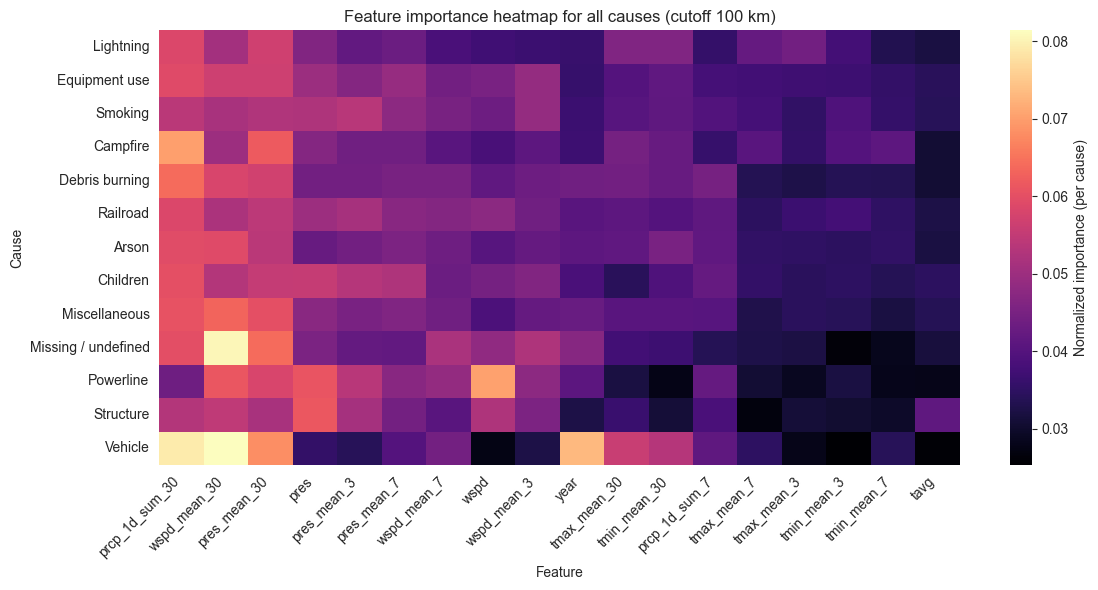

Top drivers per cause (normalized importance):
- Lightning: prcp_1d_sum_30 (0.06), pres_mean_30 (0.06), wspd_mean_30 (0.05)
- Equipment use: prcp_1d_sum_30 (0.06), wspd_mean_30 (0.06), pres_mean_30 (0.06)
- Smoking: prcp_1d_sum_30 (0.05), pres_mean_3 (0.05), pres_mean_30 (0.05)
- Campfire: prcp_1d_sum_30 (0.07), pres_mean_30 (0.06), wspd_mean_30 (0.05)
- Debris burning: prcp_1d_sum_30 (0.06), wspd_mean_30 (0.06), pres_mean_30 (0.06)
- Railroad: prcp_1d_sum_30 (0.06), pres_mean_30 (0.05), wspd_mean_30 (0.05)
- Arson: prcp_1d_sum_30 (0.06), wspd_mean_30 (0.06), pres_mean_30 (0.05)
- Children: prcp_1d_sum_30 (0.06), pres (0.06), pres_mean_30 (0.06)
- Miscellaneous: wspd_mean_30 (0.06), prcp_1d_sum_30 (0.06), pres_mean_30 (0.06)
- Missing / undefined: wspd_mean_30 (0.08), pres_mean_30 (0.06), prcp_1d_sum_30 (0.06)
- Powerline: wspd (0.07), wspd_mean_30 (0.06), pres (0.06)
- Structure: pres (0.06), wspd_mean_30 (0.05), prcp_1d_sum_30 (0.05)
- Vehicle: wspd_mean_30 (0.08), prcp_1d_sum_30 (0.

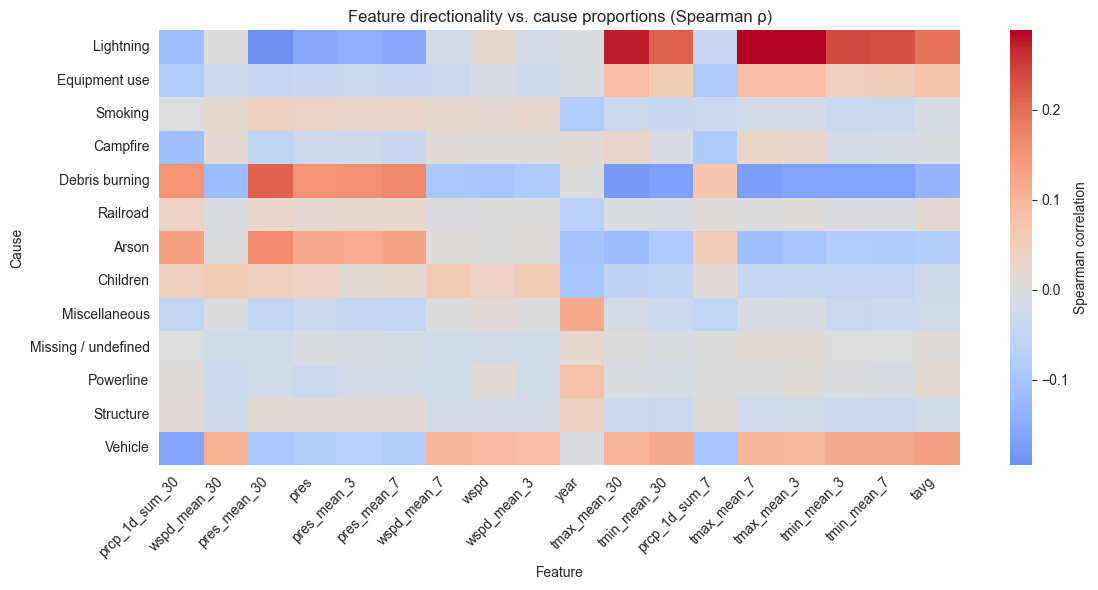

In [ ]:
# ---- 9.3a All-cause feature effect diagnostics ----
if 'cause_results' not in globals():
    raise ValueError('Run run_cutoff_report(...) first to populate cause_results.')

cutoff_used = cause_results['cutoff']
feature_cols_used = cause_results['feature_cols']
target_prop_cols = cause_results['target_prop_cols']
multi_reg = cause_results['model']


def _format_cause_label(prop_col: str) -> str:
    base_col = prop_col.replace('_prop', '')
    return CAUSE_COLUMN_TO_NAME.get(base_col, base_col)


def build_importance_matrix():
    rows = []
    for idx, cause_name in enumerate(target_prop_cols):
        reg = multi_reg.estimators_[idx]
        rows.append(reg.feature_importances_)
    fi_matrix = pd.DataFrame(
        rows,
        index=[_format_cause_label(col) for col in target_prop_cols],
        columns=feature_cols_used,
    )
    return fi_matrix


importance_matrix = build_importance_matrix()
normalized_importance = importance_matrix.div(
    importance_matrix.sum(axis=1).replace(0, np.nan), axis=0
).fillna(0)

# Rank features by their overall contribution across causes
top_feature_order = (
    importance_matrix.sum(axis=0)
    .sort_values(ascending=False)
    .head(min(18, importance_matrix.shape[1]))
    .index
)

if len(top_feature_order) > 0:
    fig, ax = plt.subplots(figsize=(min(18, 1 + 0.6 * len(top_feature_order)), 6))
    sns.heatmap(
        normalized_importance.loc[:, top_feature_order],
        cmap='magma',
        ax=ax,
        cbar_kws={'label': 'Normalized importance (per cause)'},
    )
    ax.set_title(
        f'Feature importance heatmap for all causes (cutoff {cutoff_used} km)'
    )
    ax.set_xlabel('Feature')
    ax.set_ylabel('Cause')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print('No features available to plot importances.')

print('Top drivers per cause (normalized importance):')
for cause_label in normalized_importance.index:
    top_feats = normalized_importance.loc[cause_label].sort_values(ascending=False).head(3)
    summary = ', '.join(f"{feat} ({weight:.2f})" for feat, weight in top_feats.items())
    print(f"- {cause_label}: {summary}")


# Correlation heatmap to expose directionality
if 'merged_by_cutoff' not in globals():
    raise ValueError('merged_by_cutoff is missing; rerun the data-prep cells.')

data_for_corr = merged_by_cutoff[cutoff_used].copy()
fire_mask = data_for_corr['n_fires'] > 0
feature_cols_available = [col for col in feature_cols_used if col in data_for_corr.columns]
base_cols = feature_cols_available + ['n_fires']
if not base_cols:
    raise ValueError('No overlapping features available for the correlation plot.')

corr_subset = data_for_corr.loc[fire_mask, base_cols].copy()
corr_subset['n_fires_safe'] = corr_subset['n_fires'].clip(lower=1)
for prop_col in target_prop_cols:
    base_col = prop_col.replace('_prop', '')
    if base_col in data_for_corr.columns:
        corr_subset[prop_col] = (
            data_for_corr.loc[fire_mask, base_col] / corr_subset['n_fires_safe']
        )

prop_cols_available = [col for col in target_prop_cols if col in corr_subset.columns]
if prop_cols_available:
    corr_matrix = corr_subset[feature_cols_available + prop_cols_available].corr(method='spearman')
    block = corr_matrix.loc[prop_cols_available, feature_cols_available]
    block.index = [_format_cause_label(col) for col in block.index]
    heatmap_features = [feat for feat in top_feature_order if feat in block.columns]
    if not heatmap_features:
        heatmap_features = block.columns.tolist()

    fig, ax = plt.subplots(figsize=(min(18, 1 + 0.6 * len(heatmap_features)), 6))
    sns.heatmap(
        block.loc[:, heatmap_features],
        cmap='coolwarm',
        center=0,
        ax=ax,
        cbar_kws={'label': 'Spearman correlation'},
    )
    ax.set_title('Feature directionality vs. cause proportions (Spearman ρ)')
    ax.set_xlabel('Feature')
    ax.set_ylabel('Cause')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print('Cause proportion columns were not found; skip correlation heatmap.')

## 10. Interactive Cutoff Report
Use `run_cutoff_report(d)` to retrain the three LightGBM models, plot their diagnostics, and fit the cause-proportion model for the same distance threshold. This keeps every downstream visualization tied to the selected cutoff.

Reusing cached models for cutoff 100 km.


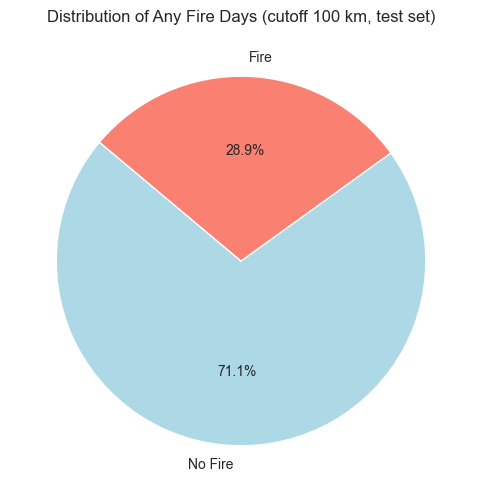

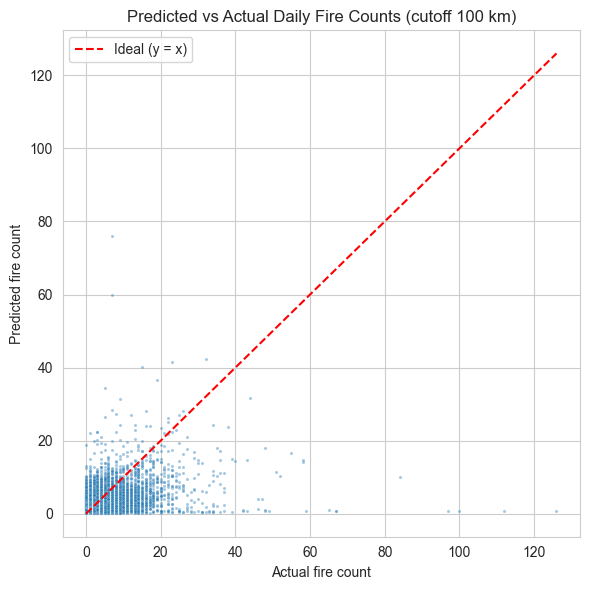

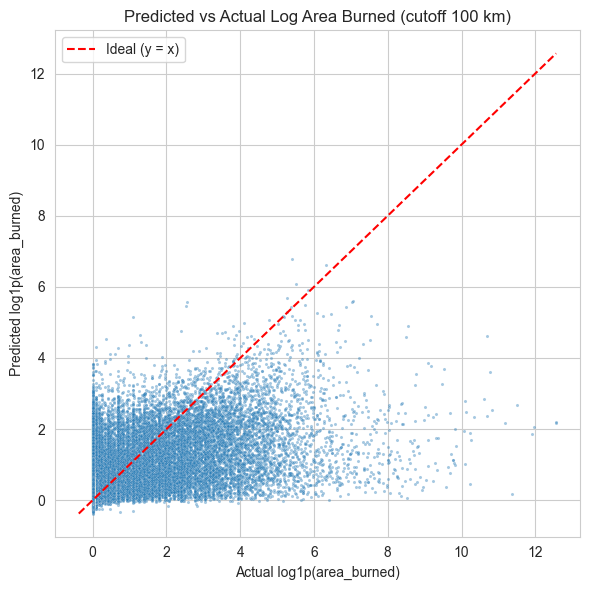

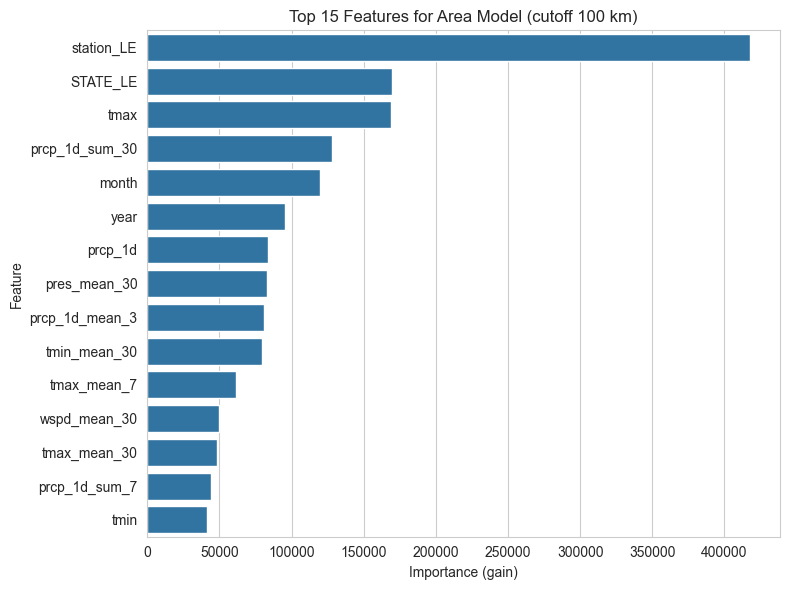

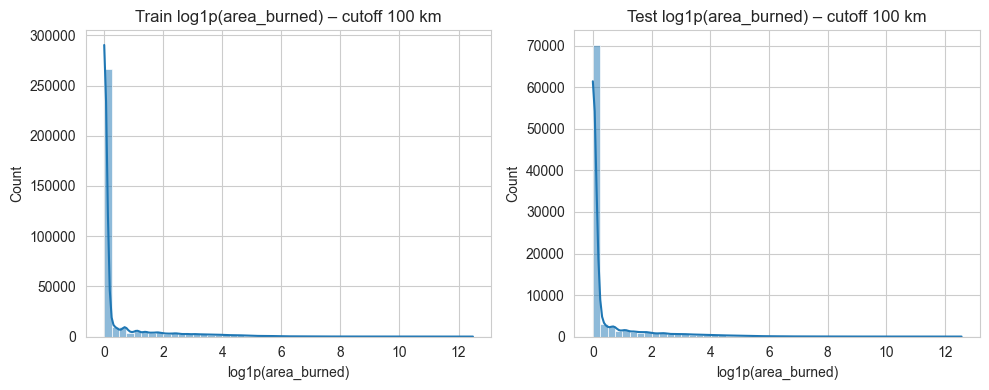

Train log-area:
count    335427.000000
mean          0.434344
std           1.112500
min           0.000000
25%           0.000000
50%           0.000000
75%           0.095310
max          12.487112
Name: log_area_burned, dtype: float64

Test log-area:
count    88738.000000
mean         0.412145
std          1.069388
min          0.000000
25%          0.000000
50%          0.000000
75%          0.095310
max         12.565414
Name: log_area_burned, dtype: float64
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5779
[LightGBM] [Info] Number of data points in the train set: 89740, number of used features: 30
[LightGBM] [Info] Start training from score 0.075173
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins

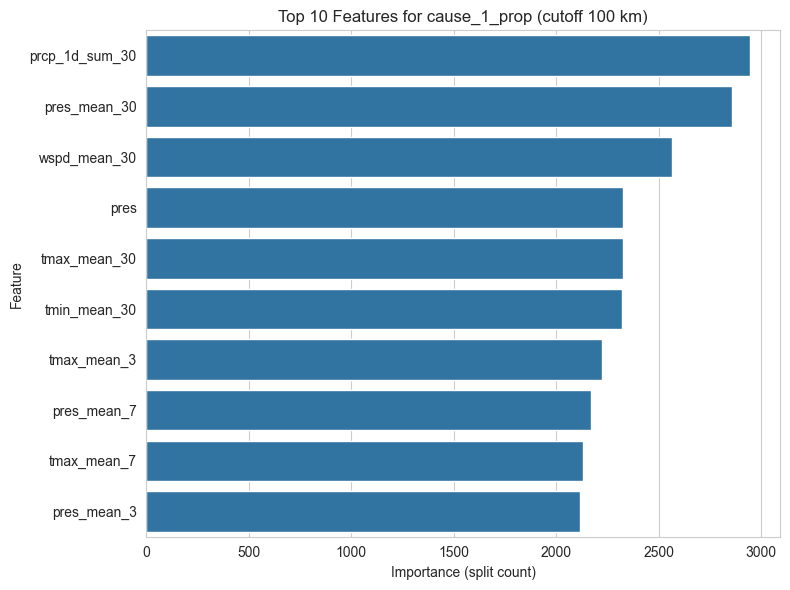

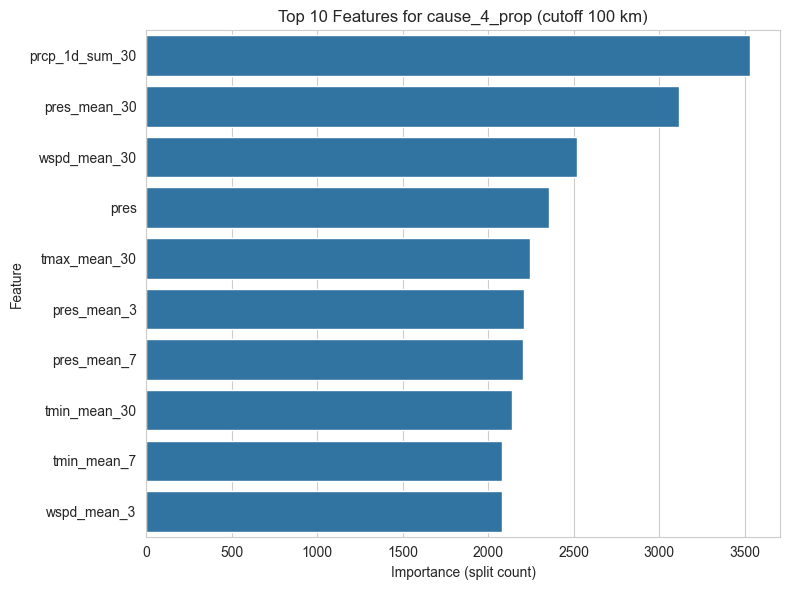

Reusing cached models for cutoff 100 km.


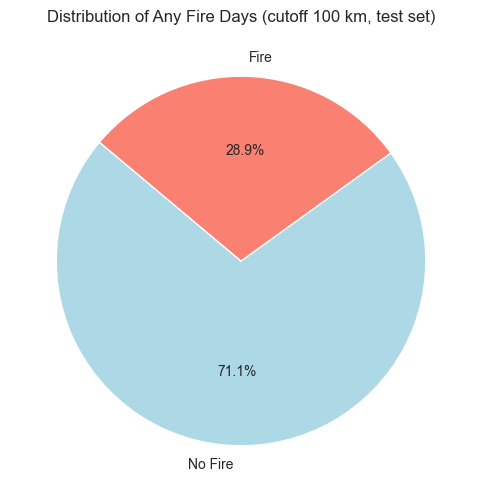

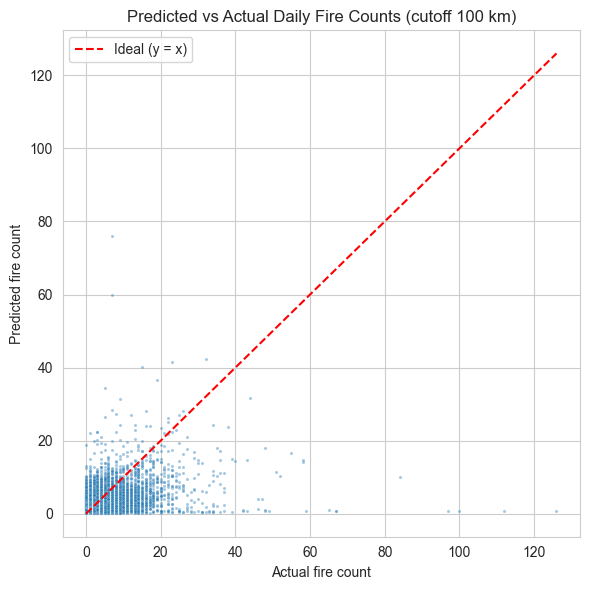

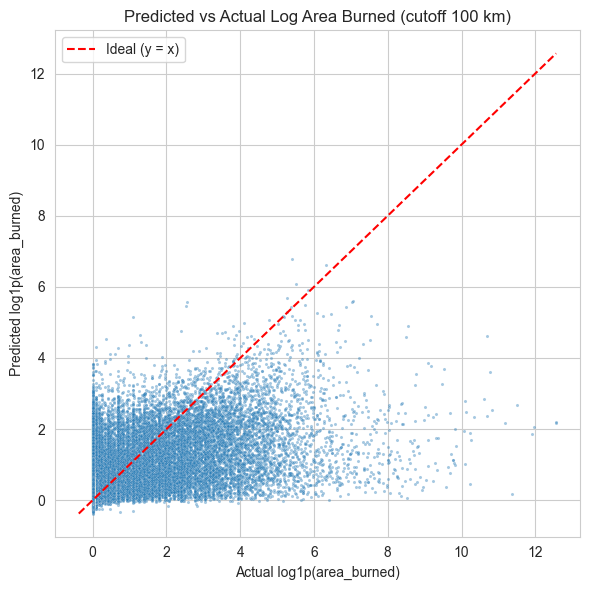

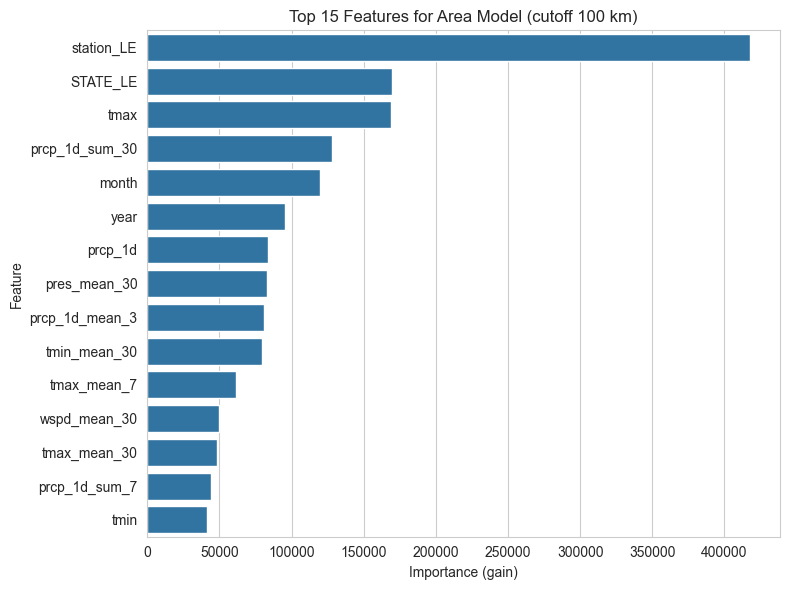

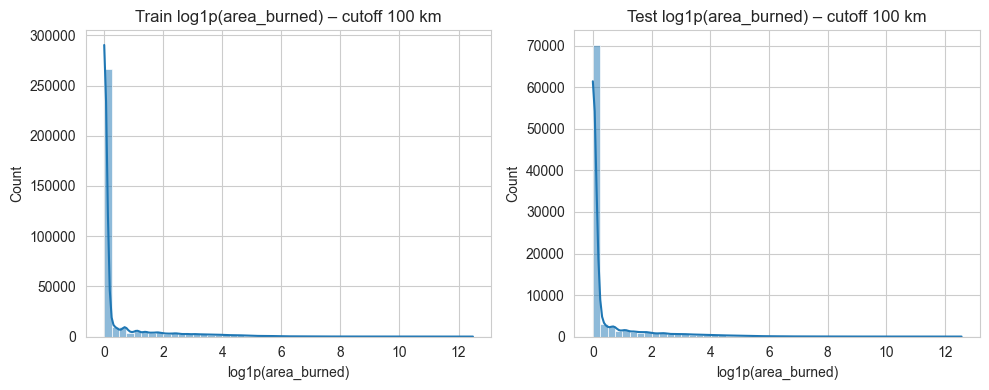

Train log-area:
count    335427.000000
mean          0.434344
std           1.112500
min           0.000000
25%           0.000000
50%           0.000000
75%           0.095310
max          12.487112
Name: log_area_burned, dtype: float64

Test log-area:
count    88738.000000
mean         0.412145
std          1.069388
min          0.000000
25%          0.000000
50%          0.000000
75%          0.095310
max         12.565414
Name: log_area_burned, dtype: float64
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5779
[LightGBM] [Info] Number of data points in the train set: 89740, number of used features: 30
[LightGBM] [Info] Start training from score 0.075173
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins

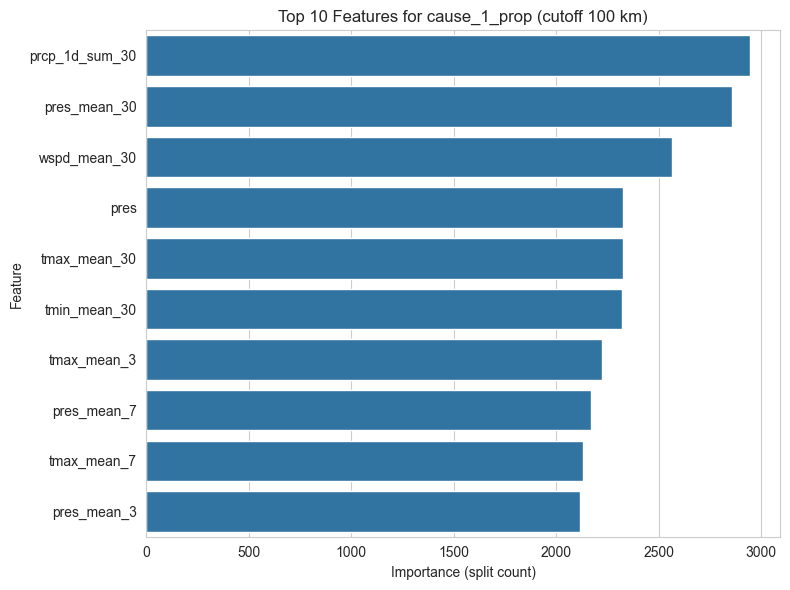

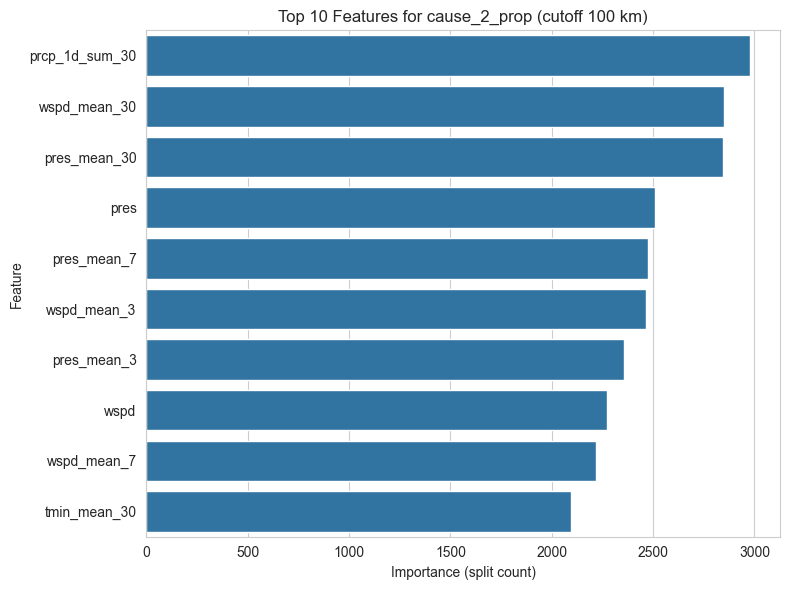

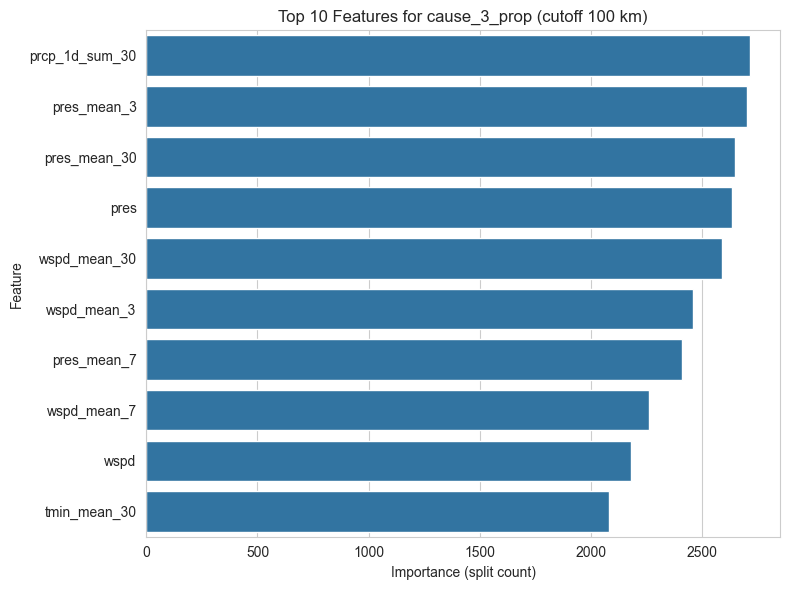

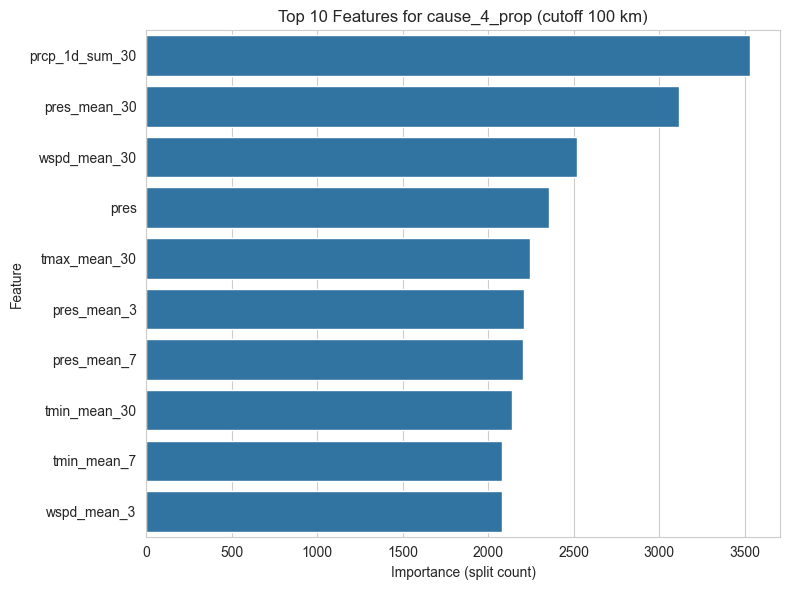

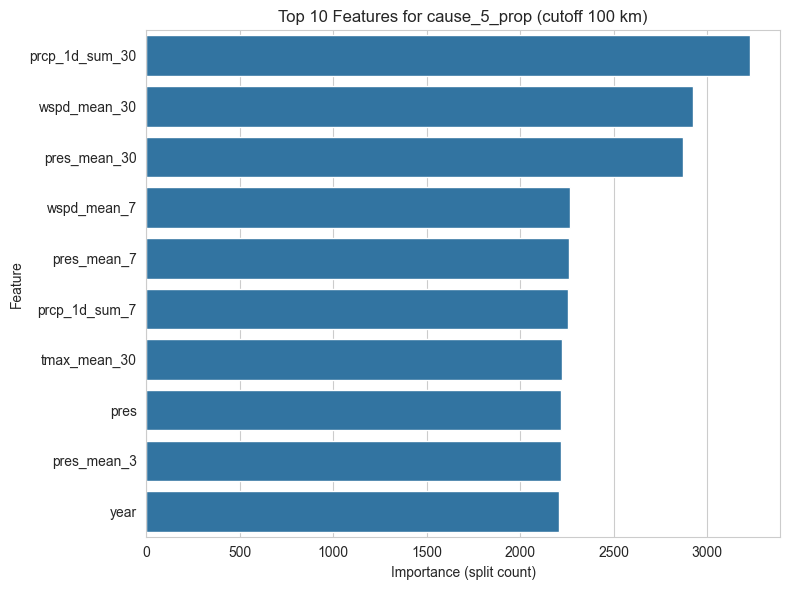

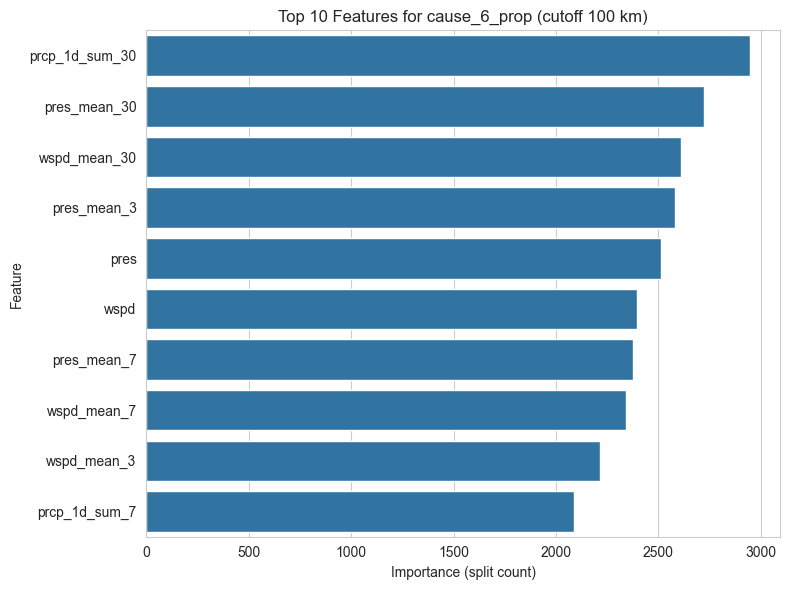

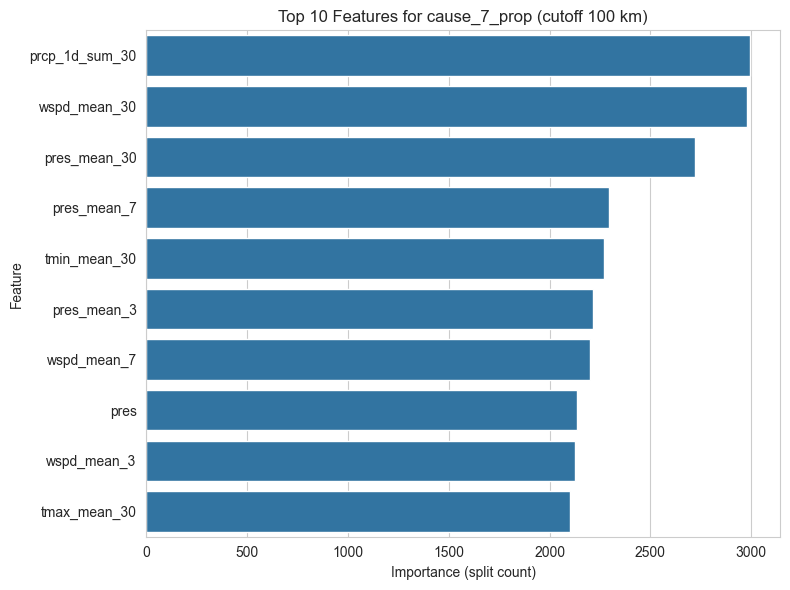

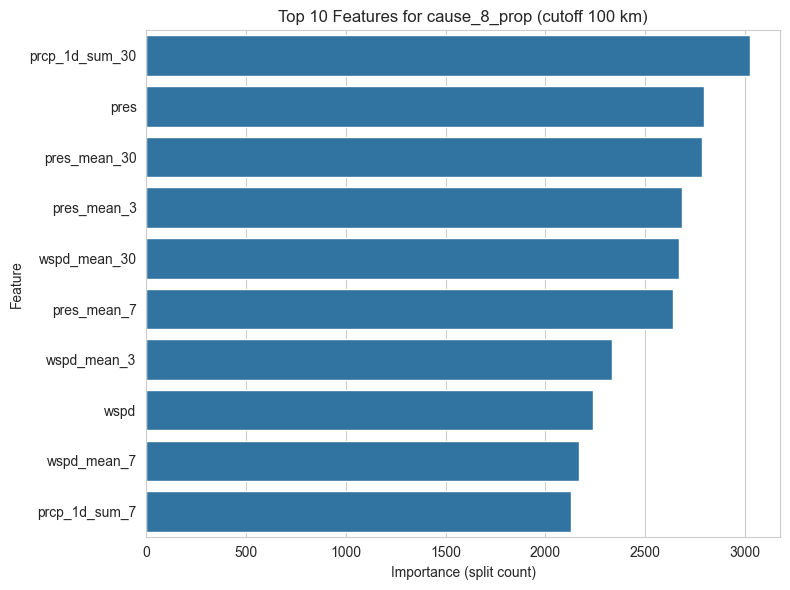

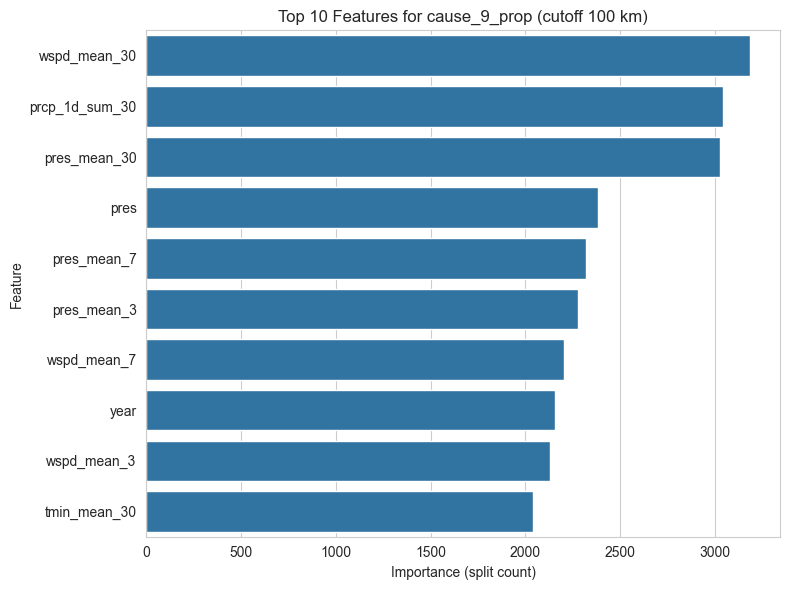

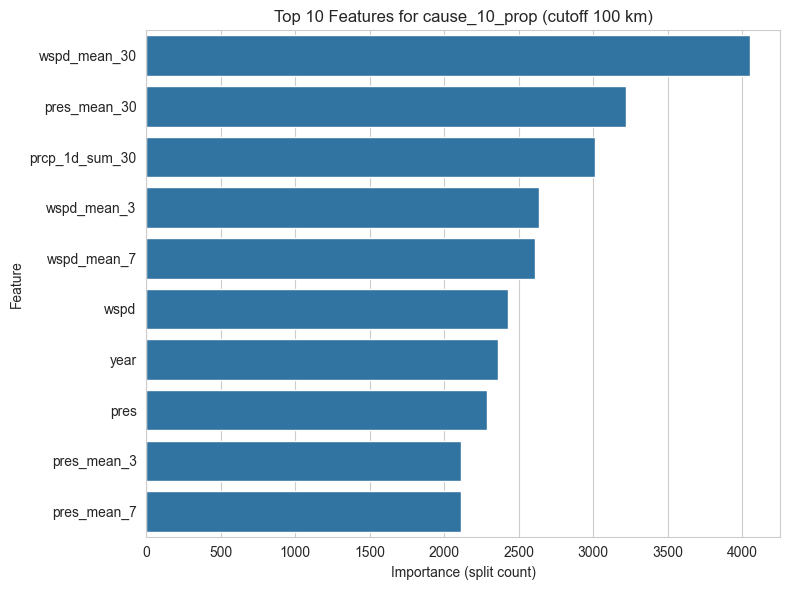

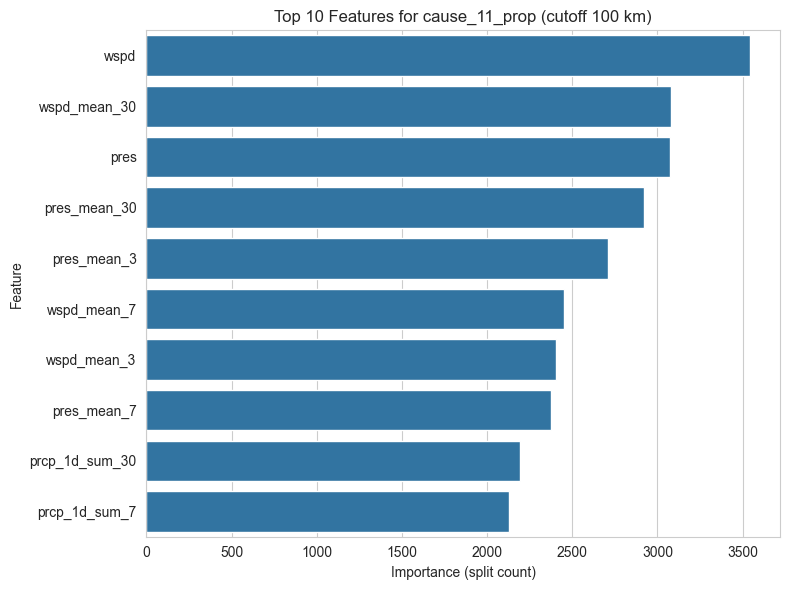

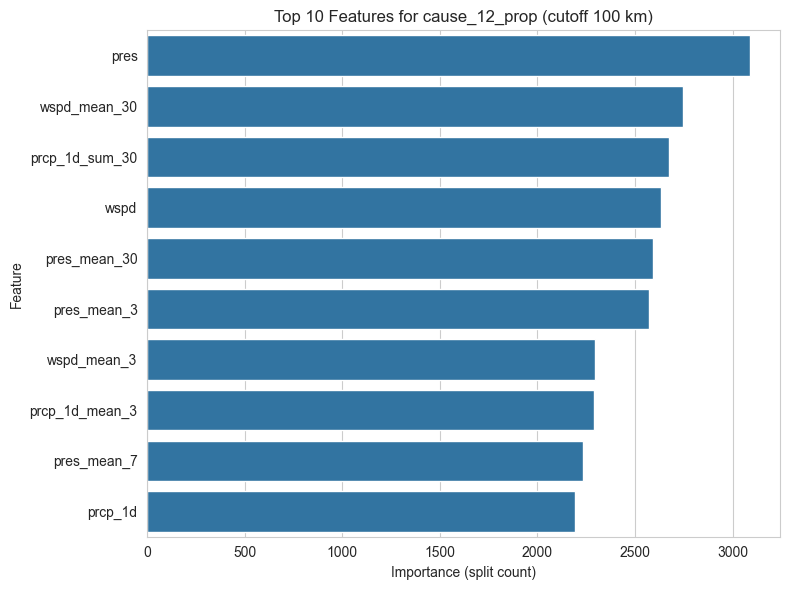

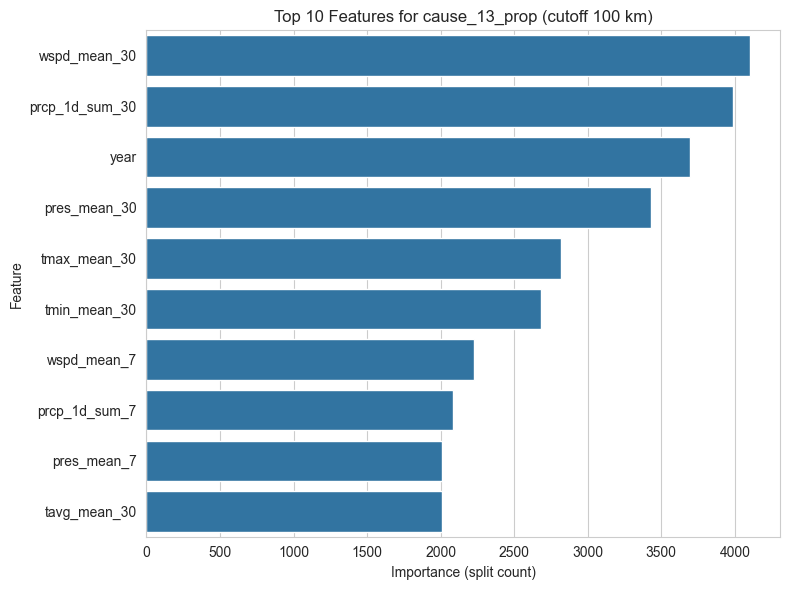

In [49]:
# Choose a cutoff to inspect (0, 100, 200, 400 km, etc.)
d_focus = 100

# Run once with a small subset of causes for quicker plots
detailed_results, cause_results = run_cutoff_report(
    d_focus,
    cause_names=['cause_1_prop', 'cause_4_prop']
)

# Reuse the cause names returned from the first run so we do not depend on
# a global variable defined elsewhere in the notebook.
all_cause_props = cause_results['target_prop_cols']
detailed_results, cause_results = run_cutoff_report(
    d_focus,
    cause_names=all_cause_props
)


### 7.3 Metric comparison bar charts
To visually compare how each distance-pruned dataset performs, the bar charts below summarize RMSE and AUC metrics per cutoff. This complements the line plots above and makes it easier to contrast discrete scenarios side by side.

## 11. Ignition vs. Spread Conditions
We contrast weather and calendar drivers of **fire ignition** (any fire vs none) against **fire spread** (low vs high burned area) using the same cutoff selected above. Differences are normalized so features on different scales can be compared side by side.

C:\Users\Kasper\AppData\Local\Temp\ipykernel_11340\1104050765.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\Kasper\AppData\Local\Temp\ipykernel_11340\1104050765.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


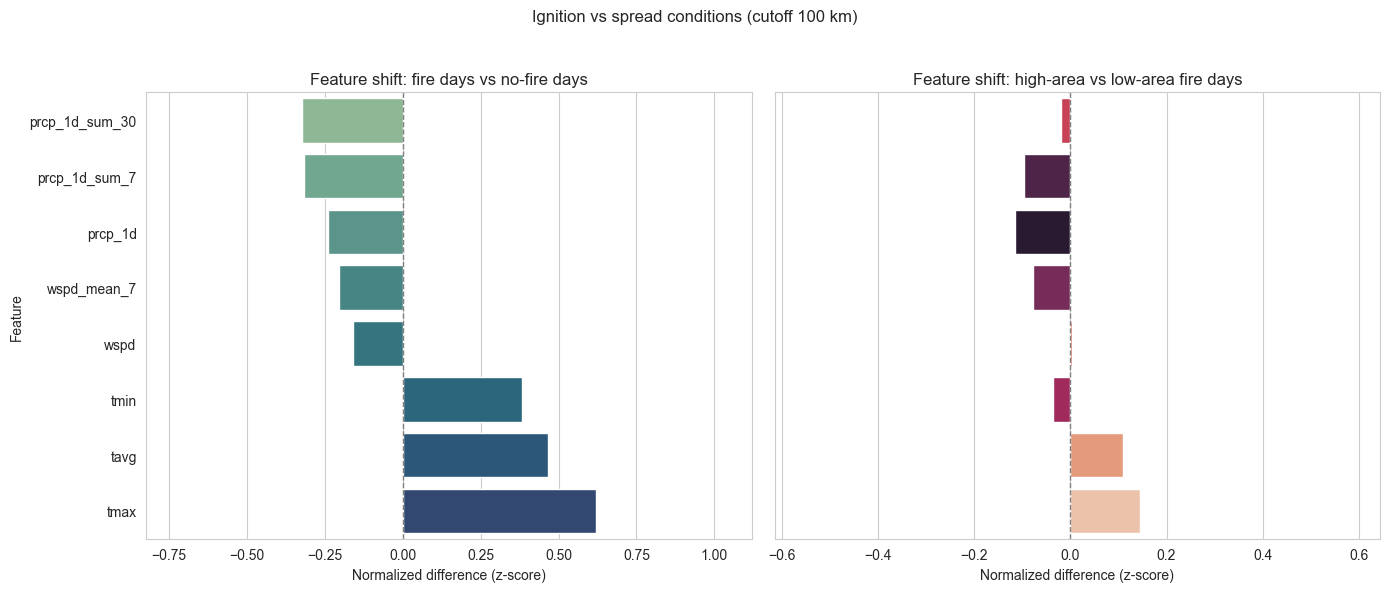

Top ignition-associated features:
       feature   delta_z
3  wspd_mean_7 -0.204201
4         wspd -0.158950
5         tmin  0.382574
6         tavg  0.466375
7         tmax  0.620596

Top spread-associated features:
          feature   delta_z
3            tmin -0.036624
4  prcp_1d_sum_30 -0.018817
5            wspd  0.003563
6            tavg  0.109271
7            tmax  0.143939


In [ ]:
# ---- 11.1 Feature deltas for ignition vs spread ----
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

if 'merged_by_cutoff' not in globals():
    raise ValueError('merged_by_cutoff missing; rerun the merge step before this analysis.')

analysis_cutoff = d_focus if 'd_focus' in globals() else 100
analysis_df = merged_by_cutoff.get(analysis_cutoff)
if analysis_df is None:
    raise ValueError(f'Cutoff {analysis_cutoff} km not found in merged_by_cutoff.')

# Candidate features spanning temperature, precipitation, wind, and pressure
feature_candidates = [
    'tavg', 'tmax', 'tmin',
    'prcp_1d', 'prcp_1d_sum_7', 'prcp_1d_sum_30',
    'wspd', 'wspd_mean_7', 'wspd_mean_30',
    'pres', 'pres_mean_7', 'pres_mean_30',
]
available_features = [f for f in feature_candidates if f in analysis_df.columns]
if len(available_features) < 6 and 'feature_cols' in globals():
    fallback = [f for f in feature_cols if f in analysis_df.columns]
    available_features = fallback[:8]
if len(available_features) == 0:
    raise ValueError('No weather features available for ignition/spread analysis.')

available_features = available_features[:8]
subset_cols = ['any_fire', 'n_fires', 'log_area_burned'] + available_features
analysis_subset = analysis_df[subset_cols].copy()
analysis_subset['log_area_burned'] = analysis_subset['log_area_burned'].fillna(0)

feature_stds = analysis_subset[available_features].std().replace(0, np.nan)

# Ignition: compare mean feature values when any_fire=1 vs 0
ignition_means = analysis_subset.groupby('any_fire')[available_features].mean()
if not {0, 1}.issubset(ignition_means.index):
    raise ValueError('Need both fire and no-fire days to compare ignition conditions.')
ignition_delta = (ignition_means.loc[1] - ignition_means.loc[0]) / feature_stds
ignition_plot = ignition_delta.sort_values().reset_index()
ignition_plot.columns = ['feature', 'delta_z']

# Spread: compare high vs low log_area days (only when a fire occurred)
spread_df = analysis_subset.loc[analysis_subset['n_fires'] > 0].copy()
if spread_df.empty:
    raise ValueError('No station-days with fires available for spread analysis.')
q25 = spread_df['log_area_burned'].quantile(0.25)
q75 = spread_df['log_area_burned'].quantile(0.75)
spread_subset = spread_df[(spread_df['log_area_burned'] <= q25) | (spread_df['log_area_burned'] >= q75)].copy()
if spread_subset.empty:
    raise ValueError('Unable to create high/low area groups for spread analysis.')
spread_subset['spread_bin'] = np.where(
    spread_subset['log_area_burned'] >= q75,
    'High area (>=75th pct)',
    'Low area (<=25th pct)'
)
spread_means = spread_subset.groupby('spread_bin')[available_features].mean()
spread_delta = (
    spread_means.loc['High area (>=75th pct)']
    - spread_means.loc['Low area (<=25th pct)']
) / feature_stds
spread_plot = spread_delta.sort_values().reset_index()
spread_plot.columns = ['feature', 'delta_z']

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
palette = sns.color_palette('coolwarm', n_colors=len(ignition_plot))

sns.barplot(
    data=ignition_plot,
    x='delta_z',
    y='feature',
    ax=axes[0],
    palette='crest'
)
axes[0].axvline(0, color='gray', linestyle='--', linewidth=1)
axes[0].set_title('Feature shift: fire days vs no-fire days')
axes[0].set_xlabel('Normalized difference (z-score)')
axes[0].set_ylabel('Feature')
axes[0].set_xlim(ignition_plot['delta_z'].min() - 0.5, ignition_plot['delta_z'].max() + 0.5)

sns.barplot(
    data=spread_plot,
    x='delta_z',
    y='feature',
    ax=axes[1],
    palette='rocket'
)
axes[1].axvline(0, color='gray', linestyle='--', linewidth=1)
axes[1].set_title('Feature shift: high-area vs low-area fire days')
axes[1].set_xlabel('Normalized difference (z-score)')
axes[1].set_ylabel('')
axes[1].set_xlim(spread_plot['delta_z'].min() - 0.5, spread_plot['delta_z'].max() + 0.5)

plt.suptitle(f'Ignition vs spread conditions (cutoff {analysis_cutoff} km)')
plt.tight_layout(rect=(0, 0, 1, 0.95))
plt.show()

print('Top ignition-associated features:')
print(ignition_plot.tail(5))
print('\nTop spread-associated features:')
print(spread_plot.tail(5))

C:\Users\Kasper\AppData\Local\Temp\ipykernel_11340\4069807611.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\Kasper\AppData\Local\Temp\ipykernel_11340\4069807611.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\Kasper\AppData\Local\Temp\ipykernel_11340\4069807611.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\Kasper\AppData\Local\Temp\ipykernel_11340\4069807611.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable t

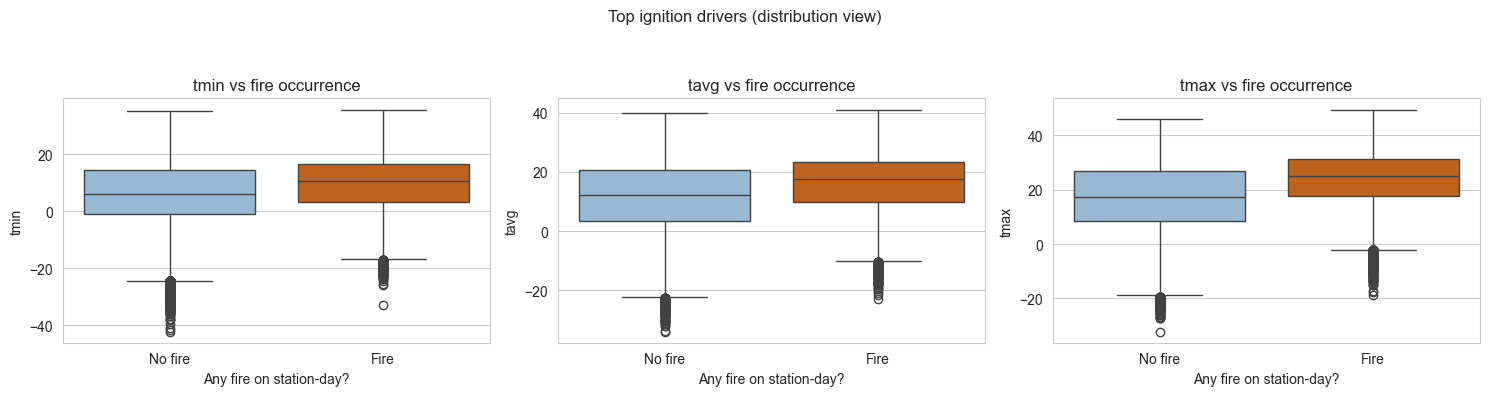

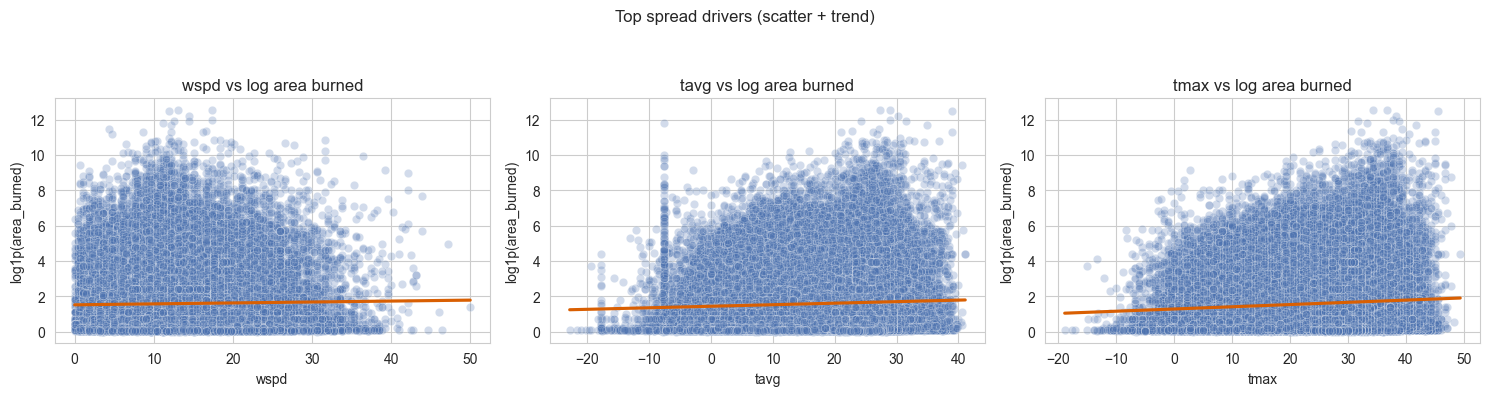

In [ ]:
# ---- 11.2 Distribution views for top ignition and spread drivers ----
required_vars = ['analysis_subset', 'spread_df', 'ignition_plot', 'spread_plot']
missing = [var for var in required_vars if var not in globals()]
if missing:
    raise ValueError(f"Missing variables {missing}; run the previous cell first.")

num_start_feats = min(3, len(ignition_plot))
num_spread_feats = min(3, len(spread_plot))
top_start_feats = ignition_plot.tail(num_start_feats)['feature'].tolist()
top_spread_feats = spread_plot.tail(num_spread_feats)['feature'].tolist()

if top_start_feats:
    fig, axes = plt.subplots(1, len(top_start_feats), figsize=(5 * len(top_start_feats), 4), sharey=False)
    if len(top_start_feats) == 1:
        axes = [axes]
    for feat, ax in zip(top_start_feats, axes):
        sns.boxplot(
            data=analysis_subset,
            x=analysis_subset['any_fire'].map({0: 'No fire', 1: 'Fire'}),
            y=feat,
            ax=ax,
            palette=['#8fb8de', '#d95f02']
        )
        ax.set_title(f'{feat} vs fire occurrence')
        ax.set_xlabel('Any fire on station-day?')
        ax.set_ylabel(feat)
    plt.suptitle('Top ignition drivers (distribution view)')
    plt.tight_layout(rect=(0, 0, 1, 0.92))
    plt.show()

if top_spread_feats:
    fig, axes = plt.subplots(1, len(top_spread_feats), figsize=(5 * len(top_spread_feats), 4), sharey=False)
    if len(top_spread_feats) == 1:
        axes = [axes]
    for feat, ax in zip(top_spread_feats, axes):
        sns.scatterplot(
            data=spread_df,
            x=feat,
            y='log_area_burned',
            alpha=0.25,
            ax=ax,
            color='#4c72b0'
        )
        sns.regplot(
            data=spread_df,
            x=feat,
            y='log_area_burned',
            scatter=False,
            ax=ax,
            color='#d95f02'
        )
        ax.set_title(f'{feat} vs log area burned')
        ax.set_xlabel(feat)
        ax.set_ylabel('log1p(area_burned)')
    plt.suptitle('Top spread drivers (scatter + trend)')
    plt.tight_layout(rect=(0, 0, 1, 0.92))
    plt.show()

## 12. Feature and Target Glossary

This section summarizes the main engineered features and targets used in this notebook.

### 12.1 Identifiers and time fields

- `station_id`: ID of the nearest weather station associated with each fire and each daily weather record.
- `STATE`: Two-letter US state abbreviation for the station.
- `date`: Calendar date (day-level granularity) for each station-day.
- `year`, `month`, `doy`: Calendar year, month (1–12), and day-of-year (1–366) derived from `date`.

### 12.2 Weather features (daily aggregates)

Base daily weather variables aggregated per station and date:

- `tavg`: Mean daily temperature (°C).
- `tmin`: Minimum daily temperature (°C).
- `tmax`: Maximum daily temperature (°C).
- `prcp_1d`: Total daily precipitation (mm) for that day.
- `wspd`: Average daily wind speed (km/h).
- `pres`: Average daily sea-level pressure (hPa).

### 12.3 Lagged and windowed weather features

To avoid look-ahead bias, rolling features are computed within each station, then shifted by 1 day so only **past** weather is used to predict fires on a given day.

For each base column in `[tavg, tmin, tmax, prcp_1d, wspd, pres]` and for window sizes 3, 7, and 30 days:

- `<col>_mean_3`, `<col>_mean_7`, `<col>_mean_30`  
  Rolling mean of the last 3, 7, or 30 days of that variable, shifted by 1 day.

For precipitation specifically:

- `prcp_1d_sum_7`, `prcp_1d_sum_30`  
  Rolling sum of daily precipitation over the last 7 or 30 days (also shifted by 1 day).
These lags capture short- and medium-term weather patterns leading up to potential fires.

### 12.4 Calendar and holiday features

- `is_weekend`: 1 if `date` is Saturday or Sunday, otherwise 0.
- `is_holiday`: 1 if the date is a US federal holiday (from the `holidays` library), otherwise 0.
- `is_july4`: 1 if the date is **Independence Day**, otherwise 0. This is a proxy for increased fire risk driven by fireworks.
- `is_weekend_or_holiday`: 1 if either `is_weekend` or `is_holiday` is 1, otherwise 0.
These features capture human behavior patterns (weekends, holidays, July 4) that can influence ignition risk.

### 12.5 Encoded identifiers

- `STATE_LE`: Integer label encoding of `STATE` (state-level categorical information).
- `station_LE`: Integer label encoding of `station_id` (station identity).
These are used as numeric proxies for location in the models.

### 12.6 Fire activity targets and cause counts

Station-day fire aggregates:

- `n_fires`: Number of fires discovered on that station-day.
- `area_burned`: Sum of `FIRE_SIZE` (area burned) across all fires on that station-day.
- `any_fire`: Binary indicator equal to 1 if at least one fire occurred (`n_fires > 0`), 0 otherwise.

Cause-specific daily counts (from pivoting `STAT_CAUSE_CODE`):

- `cause_1`, `cause_2`, ..., `cause_k`: Count of fires on that day attributed to each cause code `k`.

For the cause-proportion model (only on days with fires):

- `cause_<k>_prop`: Proportion of fires on that day attributed to cause code `k`, i.e.  
  `cause_<k>_prop = cause_<k> / n_fires`.
These per-cause proportions are used as multi-output regression targets in the `multi_reg` LightGBM model.

### 12.7 Transformed area target

- `log_area_burned`: `log1p(area_burned)`  
  A log-transform of total burned area to stabilize variance and reduce the impact of very large fires. This is the target for the **area model** (`model_area`).

### 12.8 Train/test targets used in models

- `y_train_count`, `y_test_count`: Training and test labels for the **count model** (predicting `n_fires`).
- `y_train_bin`, `y_test_bin`: Training and test labels for the **binary any-fire model** (predicting `any_fire`).
- `y_train_log_area`, `y_test_log_area`: Training and test labels for the **area model** (predicting `log_area_burned`).

Together, these features and targets allow the notebook to model:

1. How many fires occur on a given station-day.
2. Whether any fire occurs at all.
3. How much area burns (on a log scale).
4. How the mix of ignition causes varies with weather, calendar, and location.